In [ ]:
import numpy as np
from scipy.optimize import least_squares
from scipy.integrate import quad
import sympy as sp
import matplotlib.pyplot as plt
import math

In [ ]:
# Maximum value of G
G_max = 80

# Discretize x over [0, 1]
x_values = np.linspace(1e-2, 1, 1000)

In [ ]:
def jac(theta, x_vals, y_vals, G):
    omegas = theta[:G]           # omega_k
    A_k    = theta[G:2*G]        # A_k
    # bias is theta[-1] – we only need its derivative (constant 1)

    # fixed phases
    phases = (np.arange(1, G + 1) / (G + 1))          # shape (G,)

    # vectorised sine / cosine for every (x_i, k)
    x_vals = x_vals.reshape(-1, 1)                  # shape (N,1)
    sin_ωxφ = np.sin(omegas * x_vals + phases)      # shape (N,G)
    cos_ωxφ = np.cos(omegas * x_vals + phases)      # shape (N,G)

    N = x_vals.size
    J = np.empty((N, 2*G + 1), dtype=float)

    J[:, :G] = (A_k * cos_ωxφ * x_vals).astype(float)

    J[:, G:2*G] = sin_ωxφ

    J[:, -1] = 1.0

    return J

In [ ]:
# Previous constructs: fixed-phase sine functions
def construct_functions(omega_k, G):
    functions = []
    for k, omega in enumerate(omega_k):
        phase = (k + 1) / (G + 1)
        func = lambda x, omega=omega, phase=phase: np.sin(omega * x + phase)
        functions.append(func)
    return functions

# Verify orthogonality for monitoring (optional)
def verify_orthogonality(functions):
    G = len(functions)
    M = np.zeros((G, G))
    for i in range(G):
        for j in range(G):
            if i != j:
                integrand = lambda x: functions[i](x) * functions[j](x)
                M[i, j] = quad(integrand, 0, 1)[0]
    return M

# Linear least-squares with bias (used in alternating scheme or monitoring)
def approximate_function_with_bias(test_func, functions, x_values):
    G = len(functions)
    A = np.zeros((len(x_values), G + 1))
    for idx, func in enumerate(functions):
        A[:, idx] = func(x_values)
    A[:, -1] = 1  # bias column
    b = test_func(x_values)
    coeffs, *_ = np.linalg.lstsq(A, b, rcond=None)
    approx = A @ coeffs
    error = np.linalg.norm(b - approx) / np.linalg.norm(b)
    return error, coeffs[:-1], coeffs[-1], approx

# Residuals for nonlinear solve
def residuals(theta, x_vals, y_vals, G):
    omegas = theta[:G]
    A_k    = theta[G:2*G]
    bias   = theta[-1]
    phases = np.array([(k+1)/(G+1) for k in range(G)])
    model = np.zeros_like(y_vals)
    for k in range(G):
        model += A_k[k] * np.sin(omegas[k] * x_vals + phases[k])
    model += bias
    return model - y_vals

# Fit both omegas and amplitudes & bias via nonlinear least-squares
def fit_learnable_frequencies(test_func, x_values, G,
                              omega_init=None, A_init=None, bias_init=0.0):
    if omega_init is None:
        omega_init = np.linspace(1.0, G, G)
    if A_init is None:
        A_init = np.zeros(G)
    theta0 = np.hstack([omega_init, A_init, bias_init])
    y_vals = test_func(x_values)
    result = least_squares(residuals, theta0,
                           args=(x_values, y_vals, G),
                           method= 'trf', xtol=1e-8,
                           ftol=1e-8, jac=jac)
    omegas_opt = result.x[:G]
    A_k_opt   = result.x[G:2*G]
    bias_opt  = result.x[-1]
    fitted    = y_vals + residuals(result.x, x_values, y_vals, G)
    error     = np.linalg.norm(y_vals - fitted) / np.linalg.norm(y_vals)
    return omegas_opt, A_k_opt, bias_opt, error, fitted

# Main routine: initialize, verify, fit (learnable) and plot

def fit(test_func, function_name,
        omega_0, omega_0_str,
        x_values, G_max=10,
        learnable=False):
    G_values = range(1, G_max + 1)
    errors_with_bias = []
    max_off_diag     = []

    for G in G_values:
        # initial spaced frequencies
        omega_k = [omega_0 * k for k in range(G)]
        # construct fixed-phase functions
        functions = construct_functions(omega_k, G)

        # monitor orthogonality
        M = verify_orthogonality(functions)
        md = np.max(np.abs(M - np.diag(np.diag(M))))
        max_off_diag.append(md)
        print(f"G={G}: Max off-diag ortho error={md:.2e}")

        if learnable:
            # nonlinear fit of omegas, A_k, bias
            omegas_opt, A_k, bias, err, approx = \
                fit_learnable_frequencies(test_func, x_values, G,
                                          omega_init=omega_k,
                                          A_init=np.ones(G)*0.1,
                                          bias_init=0.0)
            print(f" G={G}: Learned omegas {omegas_opt}")
        else:
            # linear fit on fixed omegas
            err, A_k, bias, approx = \
                approximate_function_with_bias(test_func, functions, x_values)

        errors_with_bias.append(err)
        print(f"G={G}: Approx error={err:.2e}, bias={bias:.2e}\n")

    # plotting
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(8, 5), dpi=300)
    plt.plot(G_values, max_off_diag, 'o-')
    plt.xlabel('G')
    plt.ylabel('Max Off-Diagonal Error')
    plt.title('Orthogonality Monitor')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 5), dpi=300)
    plt.plot(G_values, errors_with_bias, 's--',
             label='learnable' if learnable else 'fixed')
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('G'); plt.ylabel('Approximation Error')
    plt.title(f"SineKAN Error vs G ({function_name})")
    plt.legend(); plt.grid(True)
    plt.show()

    return errors_with_bias, max_off_diag

In [ ]:
def inv_sine_exponential(x):
    output = np.exp(-1/x)*np.sin(1/x)
    return output

def sine_exponential(x, k=10):
    output = 0
    for i in range(k):
        output += np.exp(k*x/np.pi)*np.sin(k*x)
    return output

def sine_with_phase(x, k=10):
    output = 0
    for i in range(k):
        output = np.exp(-1/x)*np.sin(k*x + np.pi/k)
    return output

def root_sine_low(x, alpha=0.2):
    output = x**alpha*np.sin(1/x)
    return output

def root_sine_high(x, alpha=0.8):
    output = x**alpha*np.sin(1/x)
    return output

test_funcs = [inv_sine_exponential, sine_exponential, sine_with_phase, root_sine_low, root_sine_high]
function_names_latex = [
    r"$f(x) = e^{-\frac{1}{x}} \sin\left(\frac{1}{x}\right)$",
    r"$f(x) = \Sigma_k e^{\frac{kx}{\pi}} \sin(kx)$",
    r"$f(x) = \Sigma_k e^{-\frac{1}{x}} \sin\left(kx + \frac{\pi}{k}\right)$",
    r"$f(x) = x^{\frac{1}{5}} \sin\left(\frac{1}{x}\right)$",
    r"$f(x) = x^{\frac{4}{5}} \sin\left(\frac{1}{x}\right)$",
]

G=1: Max off-diag ortho error=0.00e+00
 G=1: Learned omegas [0.00167204]
G=1: Approx error=1.71e-01, bias=-1.34e+02

G=2: Max off-diag ortho error=1.64e-01
 G=2: Learned omegas [-2.61851612 -2.94713371]
G=2: Approx error=5.14e-02, bias=4.37e-01

G=3: Max off-diag ortho error=1.38e-01
 G=3: Learned omegas [0.25239246 2.23427202 5.4014692 ]
G=3: Approx error=4.33e-02, bias=-2.36e-02

G=4: Max off-diag ortho error=1.16e-01
 G=4: Learned omegas [0.20496009 1.32701029 9.88746651 9.65470252]
G=4: Approx error=1.88e-02, bias=-4.92e-01

G=5: Max off-diag ortho error=9.98e-02
 G=5: Learned omegas [ 4.97916989  4.78171195 16.5854428  16.61954193 16.97632858]
G=5: Approx error=4.97e-03, bias=1.48e-01

G=6: Max off-diag ortho error=8.70e-02
 G=6: Learned omegas [ 3.60423171  3.76058432 12.97784987 22.23622844 25.15116277 25.15605296]
G=6: Approx error=2.58e-03, bias=1.10e-01

G=7: Max off-diag ortho error=7.69e-02
 G=7: Learned omegas [ 0.34896007  3.3594118   6.3094959  18.07663125 20.28372599 20

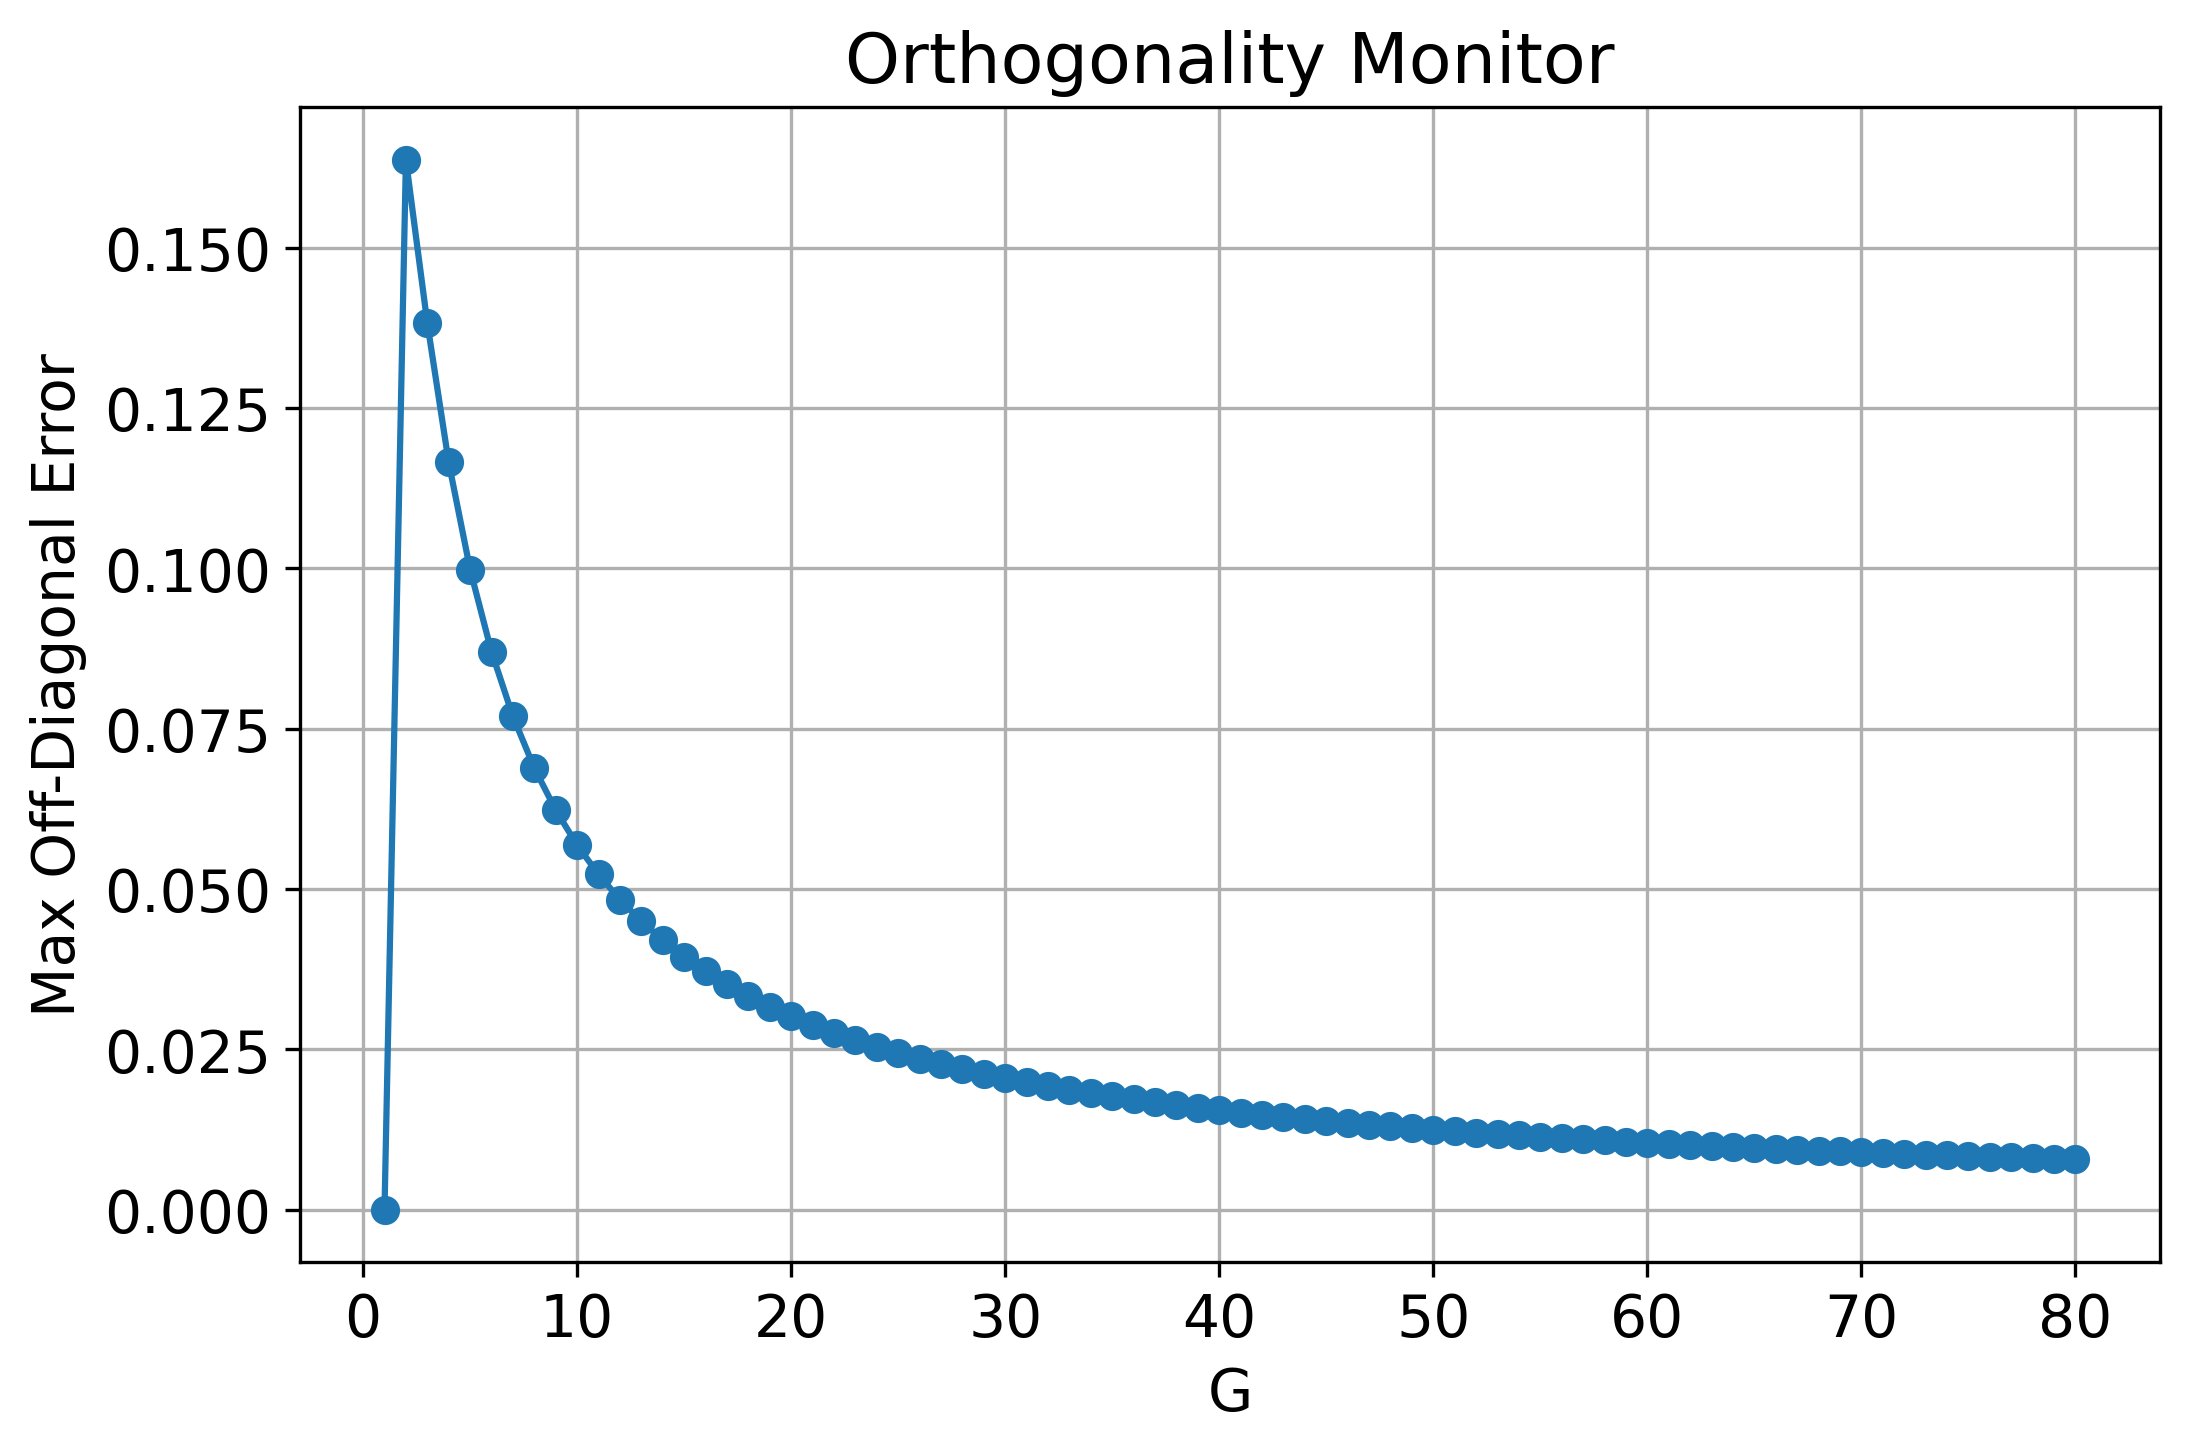

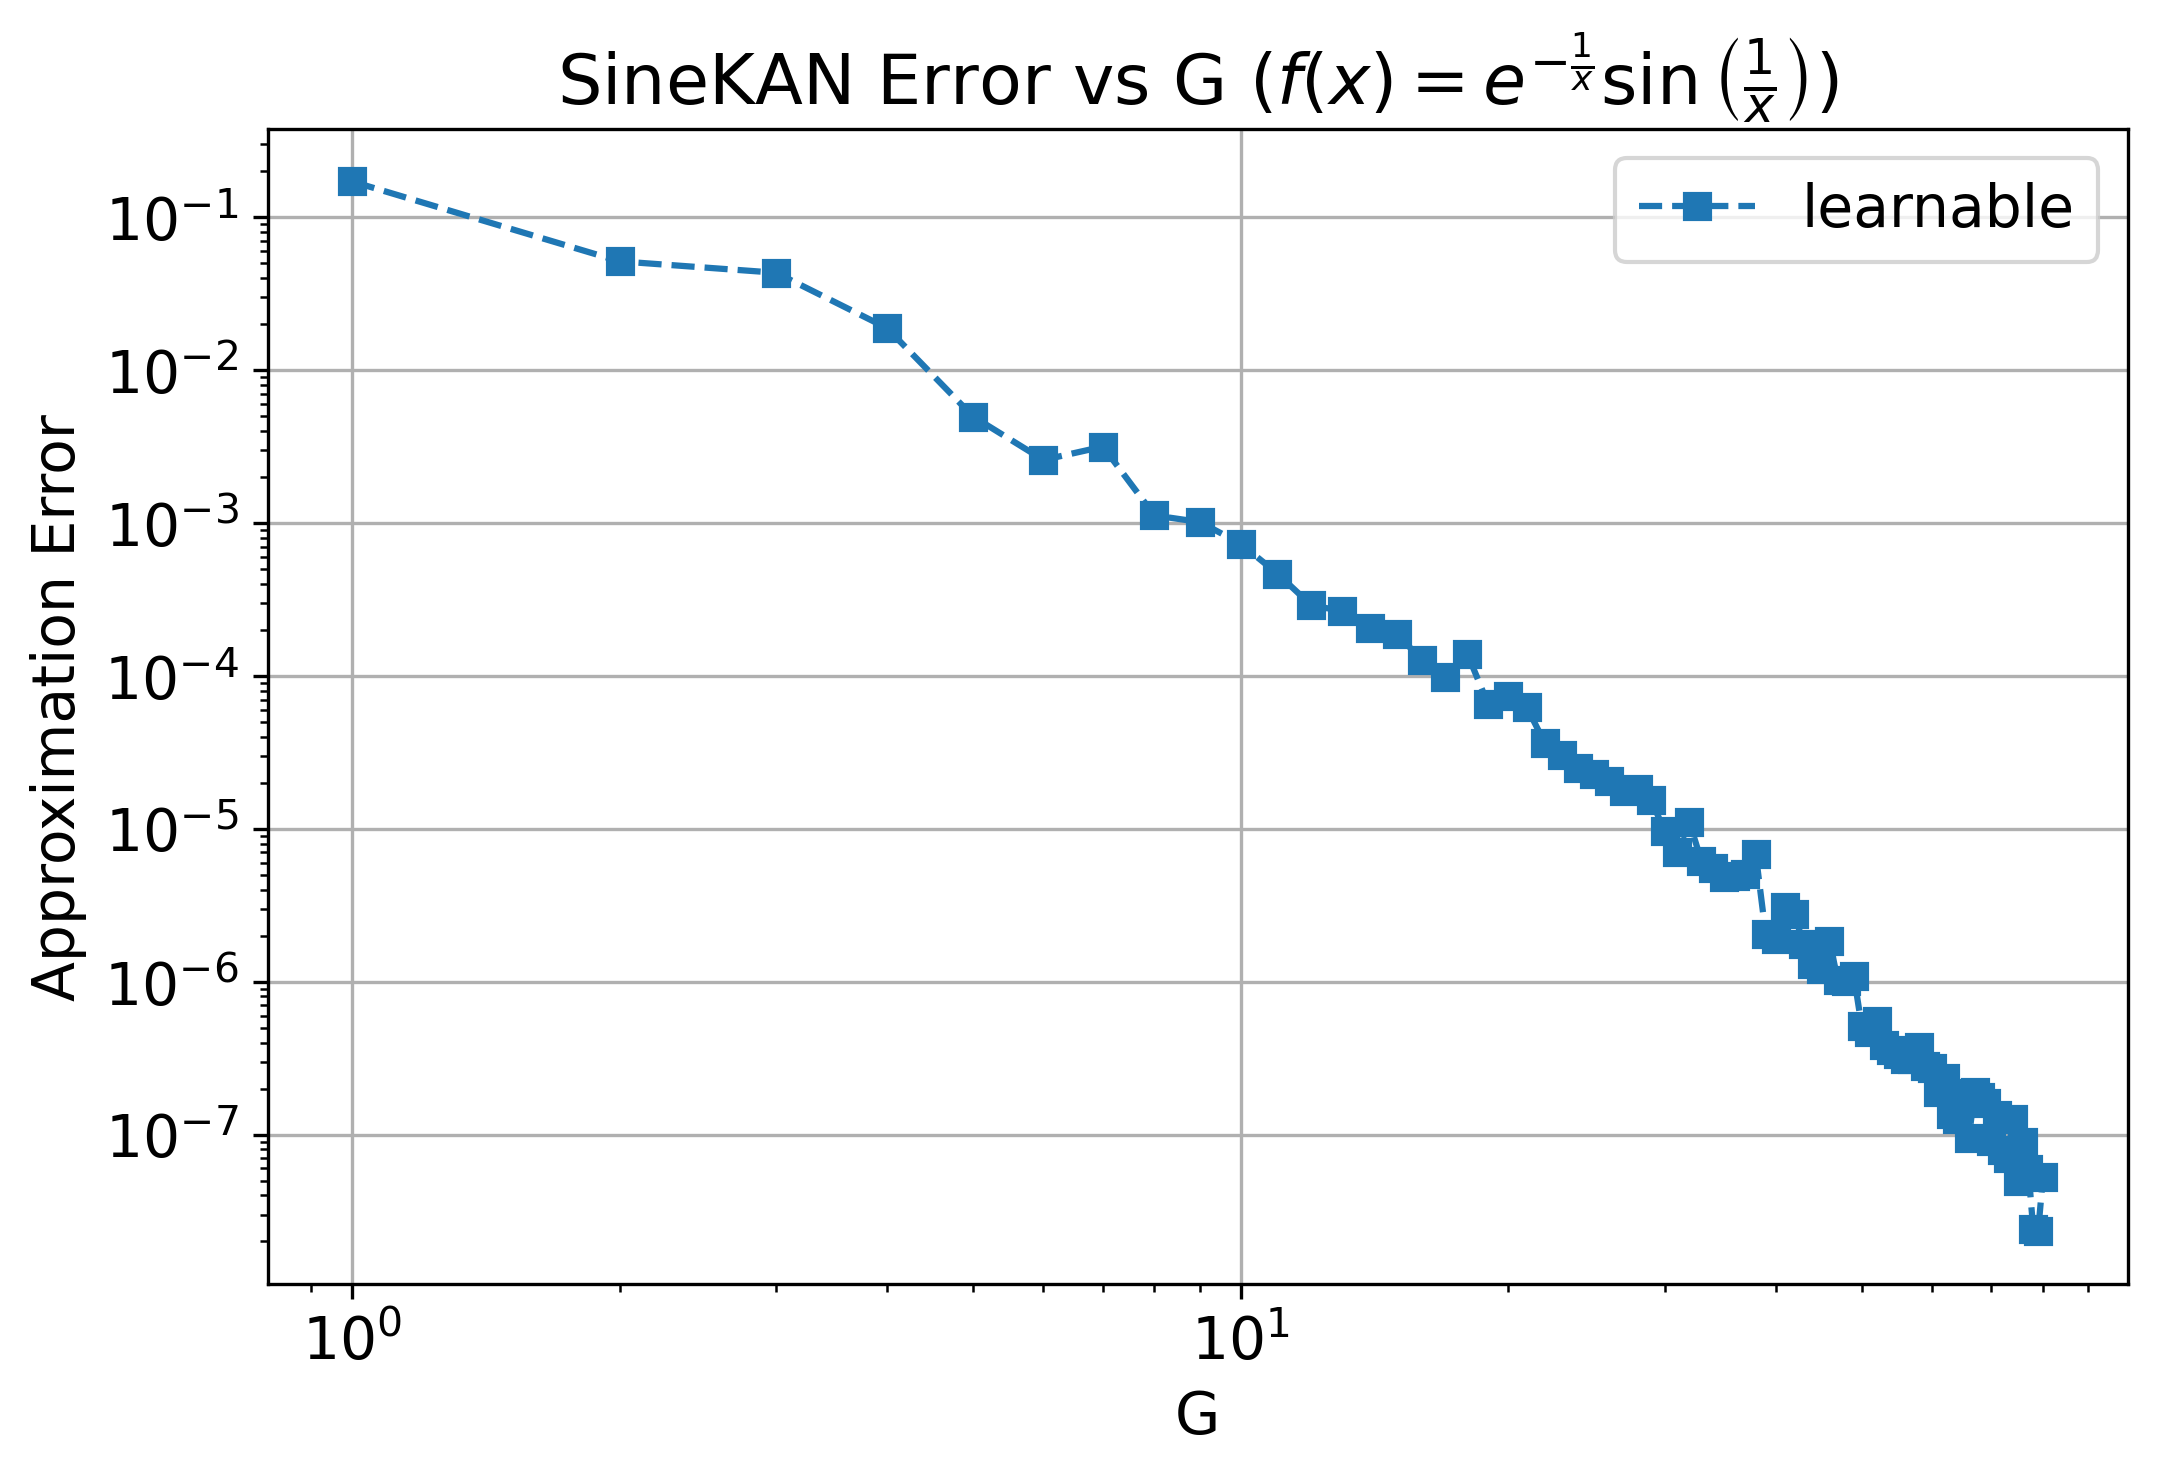

G=1: Max off-diag ortho error=0.00e+00
 G=1: Learned omegas [0.90563201]
G=1: Approx error=9.47e-01, bias=-1.24e+00

G=2: Max off-diag ortho error=1.64e-01
 G=2: Learned omegas [-0.3176468   4.51829121]
G=2: Approx error=7.69e-01, bias=-1.20e+02

G=3: Max off-diag ortho error=1.38e-01
 G=3: Learned omegas [-1.26409801  4.88809523 -1.70821849]
G=3: Approx error=7.76e-01, bias=4.35e+01

G=4: Max off-diag ortho error=1.16e-01
 G=4: Learned omegas [ -2.57882404   1.66923985 -10.46720483   9.21817303]
G=4: Approx error=4.37e-01, bias=-2.77e+01

G=5: Max off-diag ortho error=9.98e-02
 G=5: Learned omegas [0.06094359 7.03900029 7.50072106 7.98870222 8.94583843]
G=5: Approx error=8.52e-03, bias=-2.40e+02

G=6: Max off-diag ortho error=8.70e-02
 G=6: Learned omegas [-5.08417291  7.0529153   7.92712921  9.00267998  9.97797487 11.1720967 ]
G=6: Approx error=8.98e-04, bias=5.47e+00

G=7: Max off-diag ortho error=7.69e-02
 G=7: Learned omegas [-0.62876049  0.34378033  7.85637551 10.14186235 11.5825

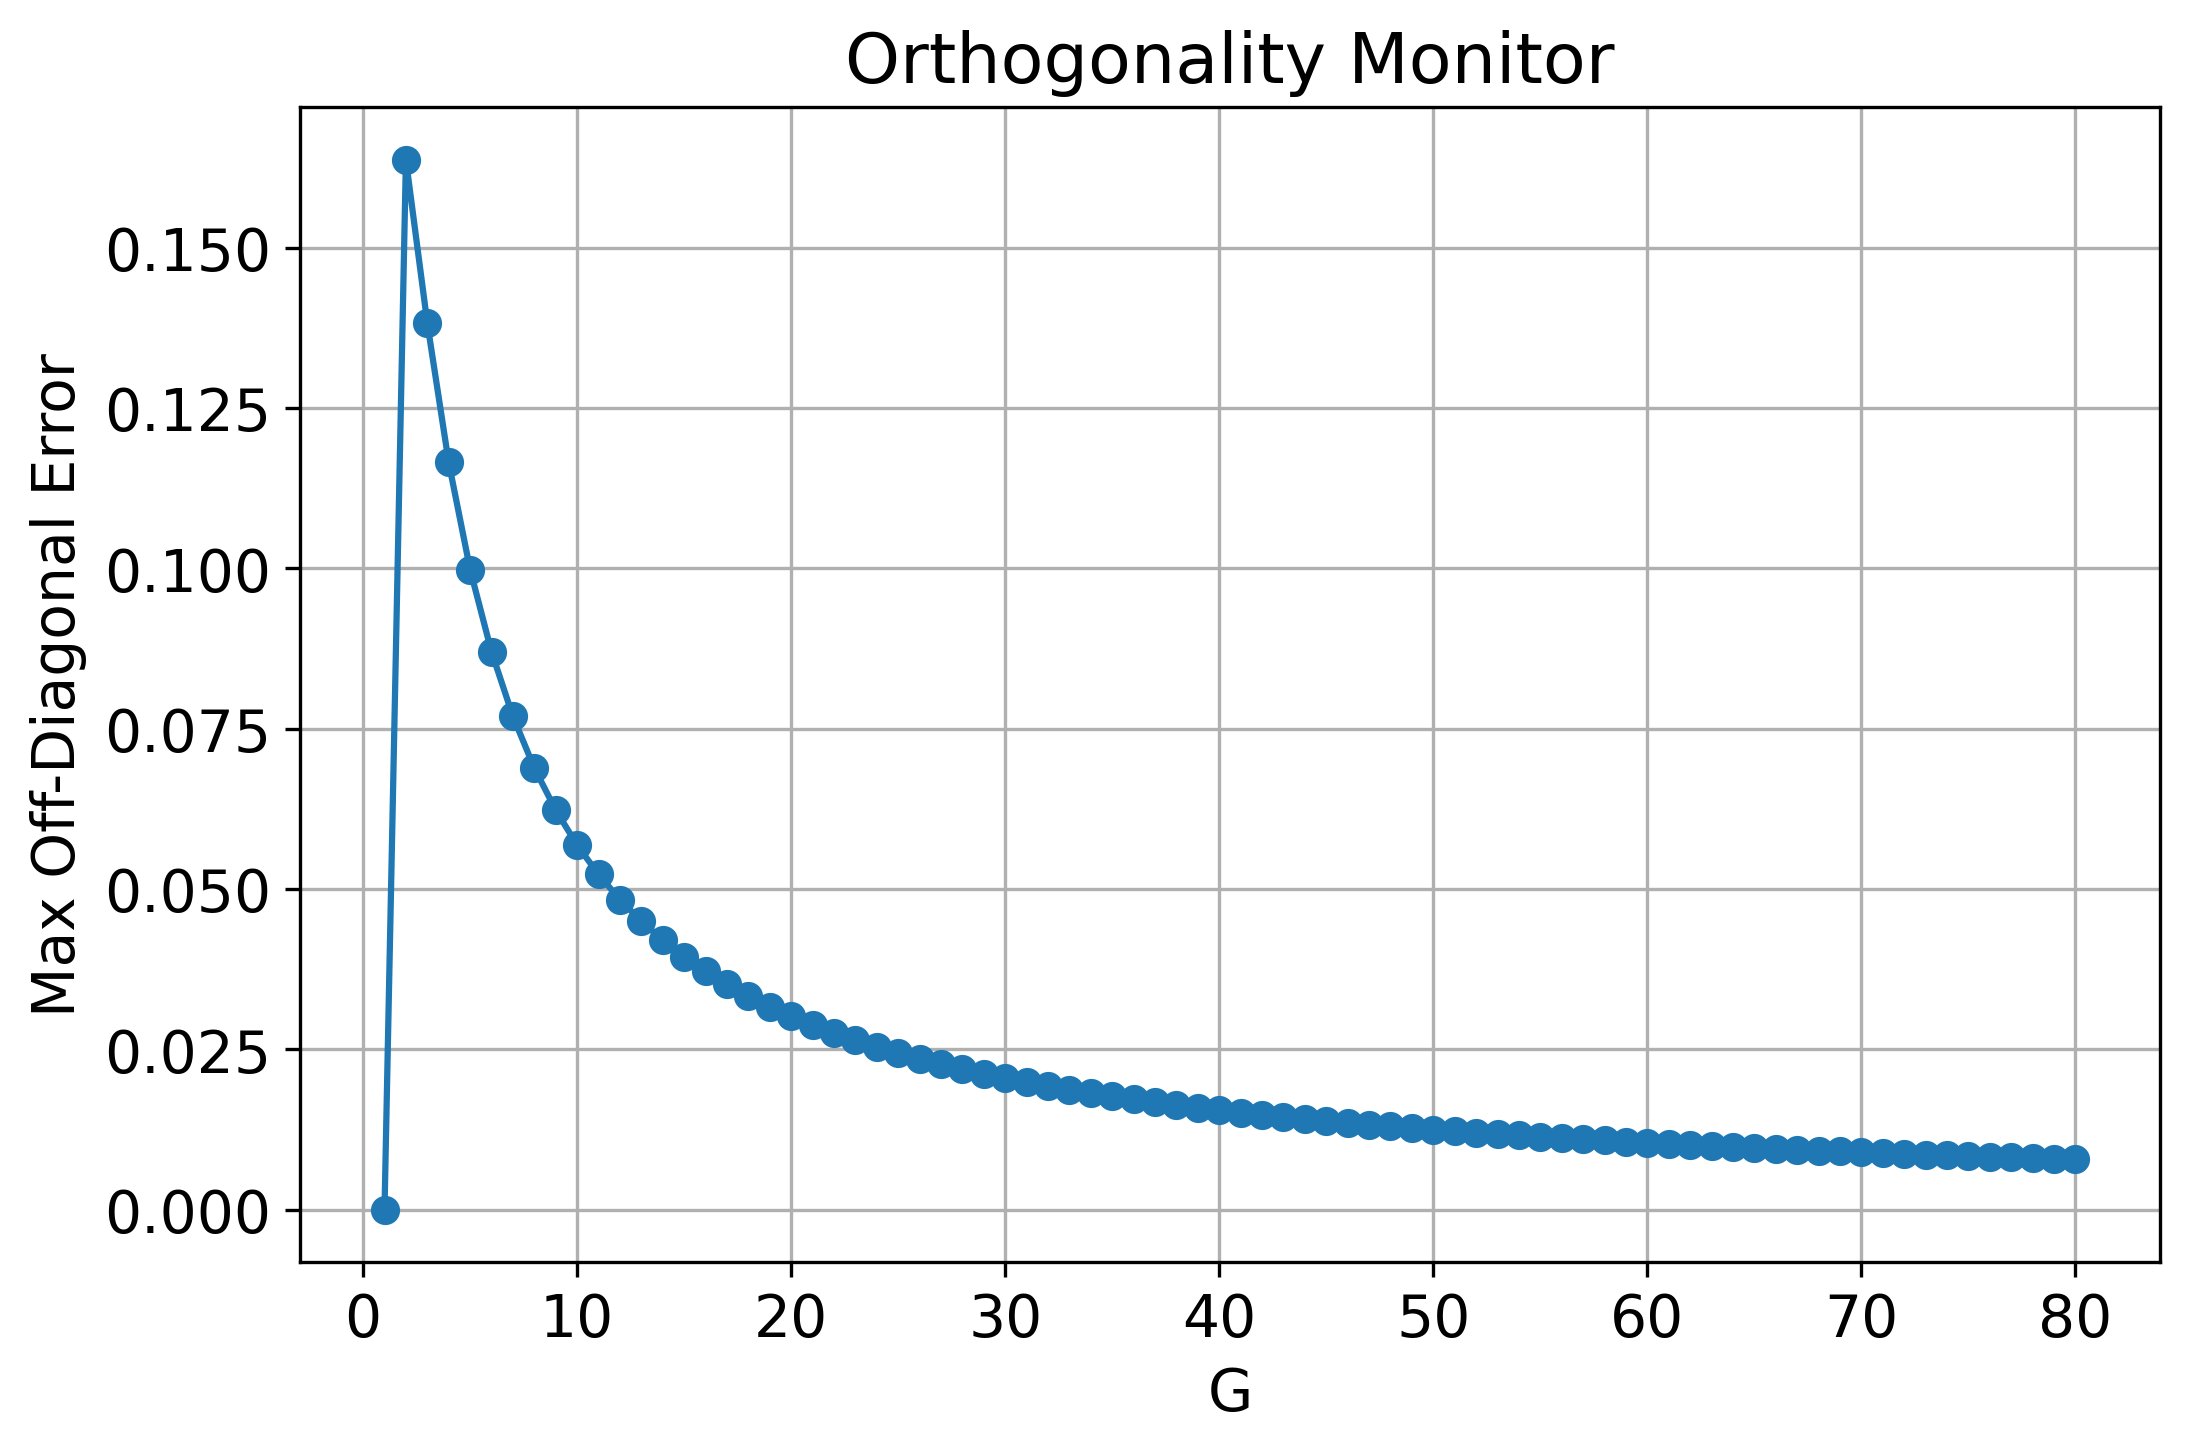

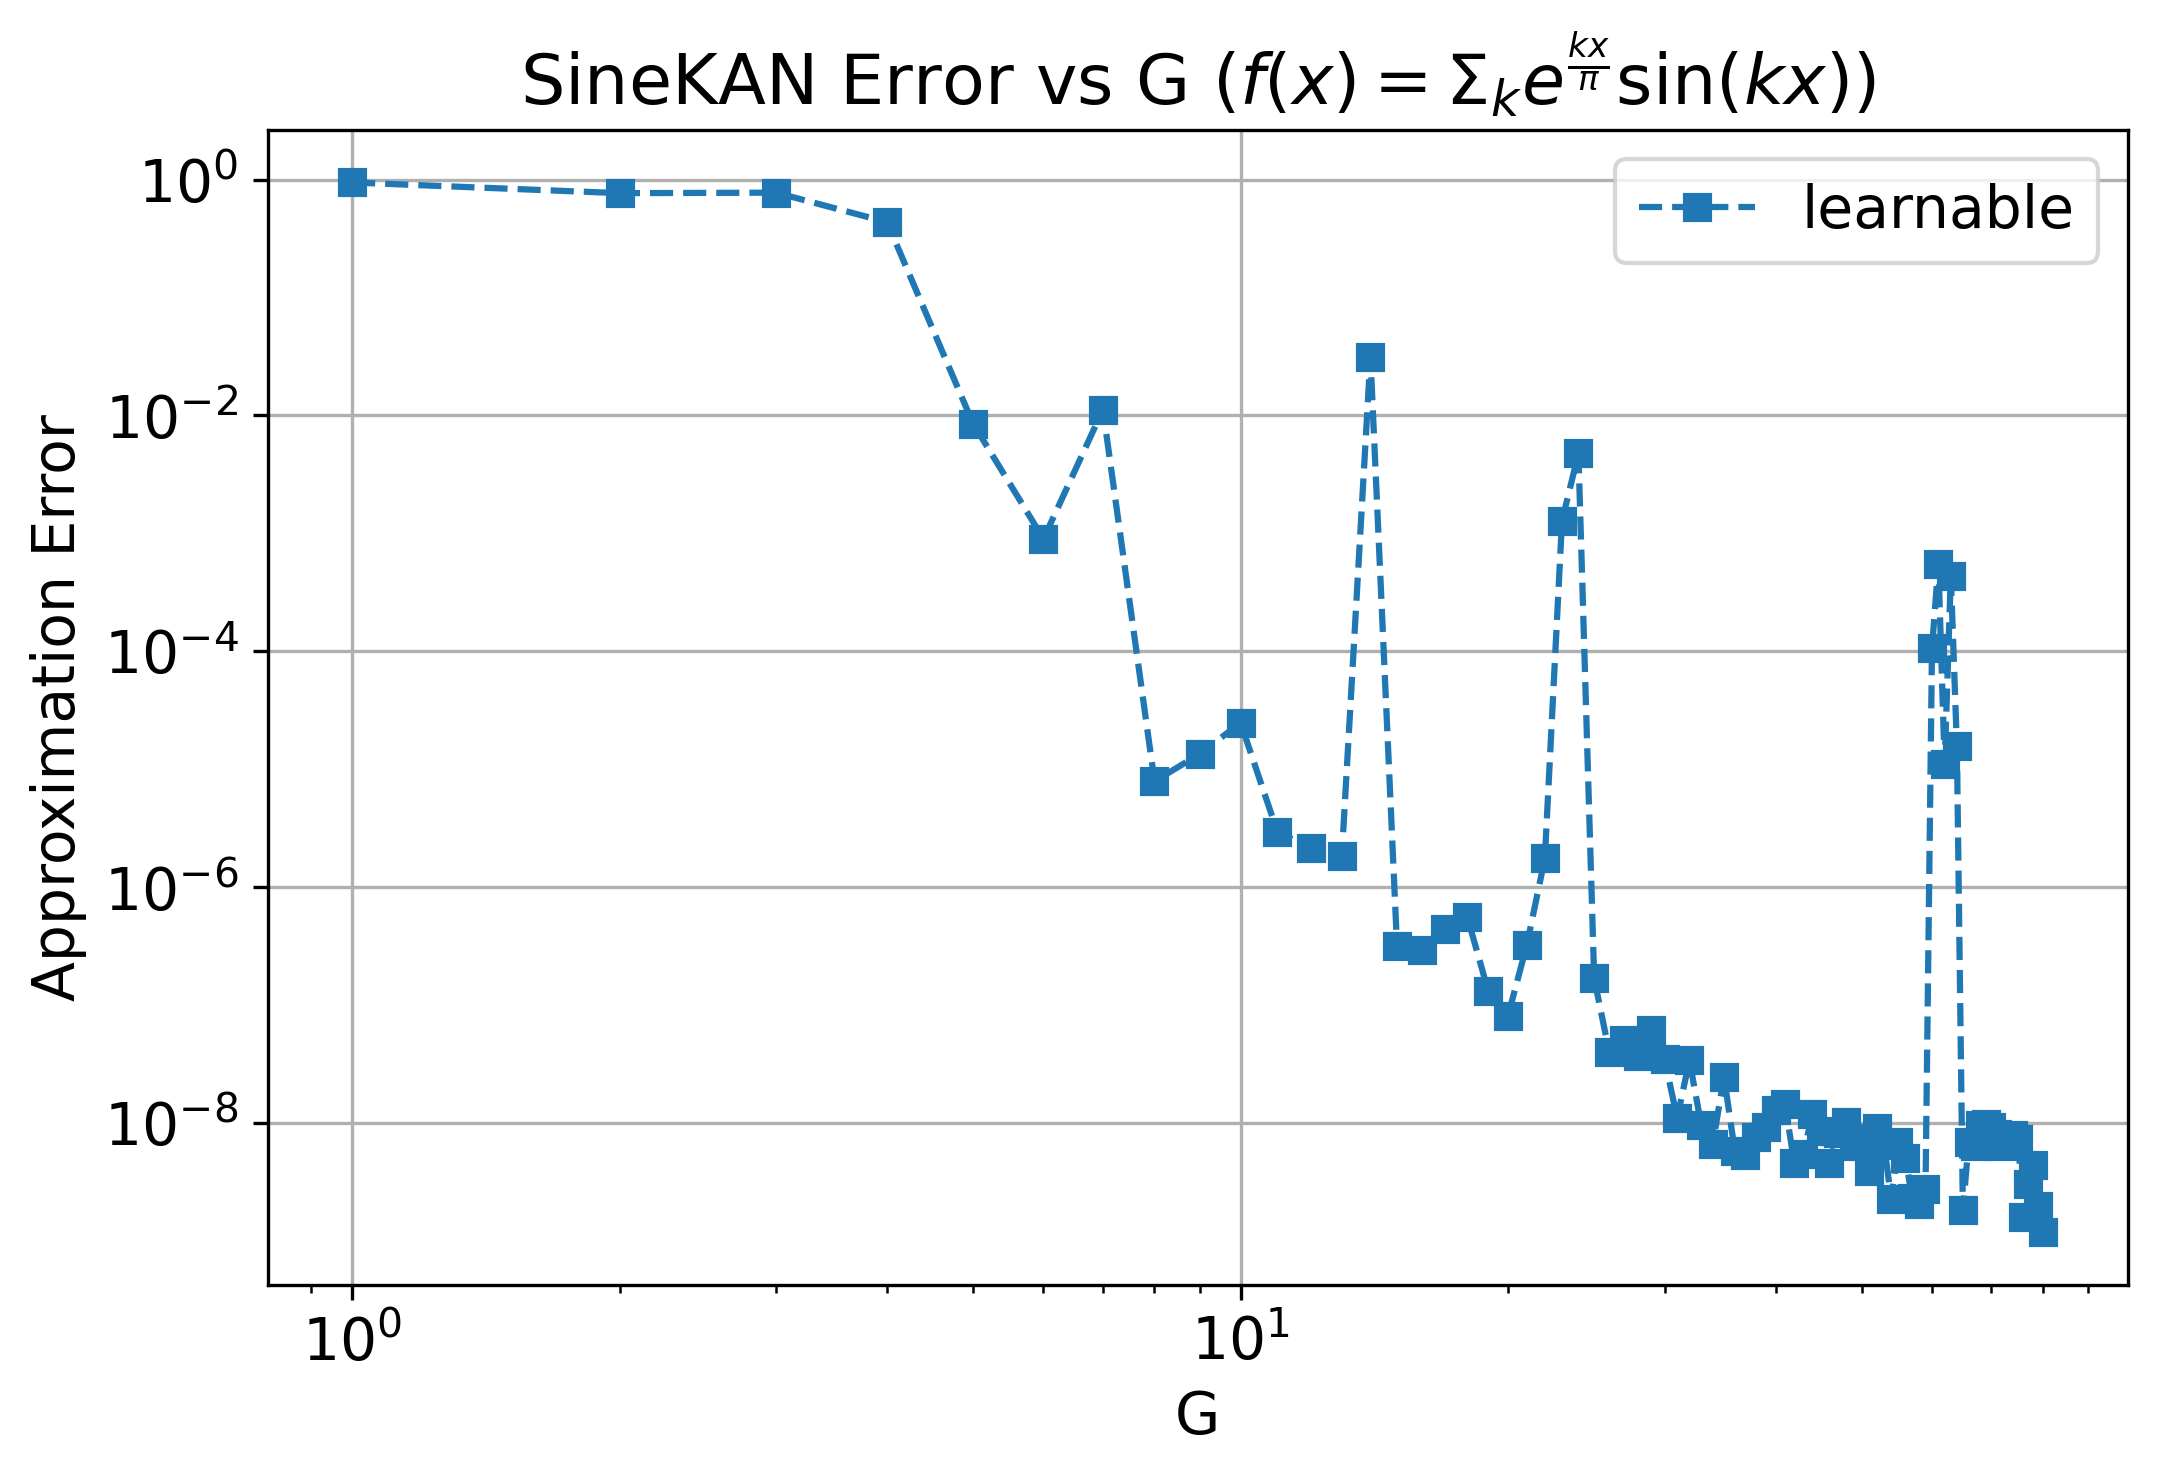

G=1: Max off-diag ortho error=0.00e+00
 G=1: Learned omegas [1.34790892]
G=1: Approx error=9.55e-01, bias=-1.60e-01

G=2: Max off-diag ortho error=1.64e-01
 G=2: Learned omegas [-0.84236947  0.08195137]
G=2: Approx error=7.15e-01, bias=3.77e+02

G=3: Max off-diag ortho error=1.38e-01
 G=3: Learned omegas [-0.04982135  1.01301165  8.74919714]
G=3: Approx error=3.14e-01, bias=-1.16e+01

G=4: Max off-diag ortho error=1.16e-01
 G=4: Learned omegas [ 2.28647569  9.50985076  7.14029663 11.98568165]
G=4: Approx error=3.39e-02, bias=1.91e-01

G=5: Max off-diag ortho error=9.98e-02
 G=5: Learned omegas [ 2.33968452 11.20933984 11.6754468  11.72914607 14.69350136]
G=5: Approx error=3.55e-03, bias=-1.52e-01

G=6: Max off-diag ortho error=8.70e-02
 G=6: Learned omegas [-0.24386203  1.2750059  11.08746731 10.67080054 12.57952634 20.54949331]
G=6: Approx error=2.28e-03, bias=-5.12e-01

G=7: Max off-diag ortho error=7.69e-02
 G=7: Learned omegas [-0.6995742   4.66746613  3.43812626  7.81339719  7.377

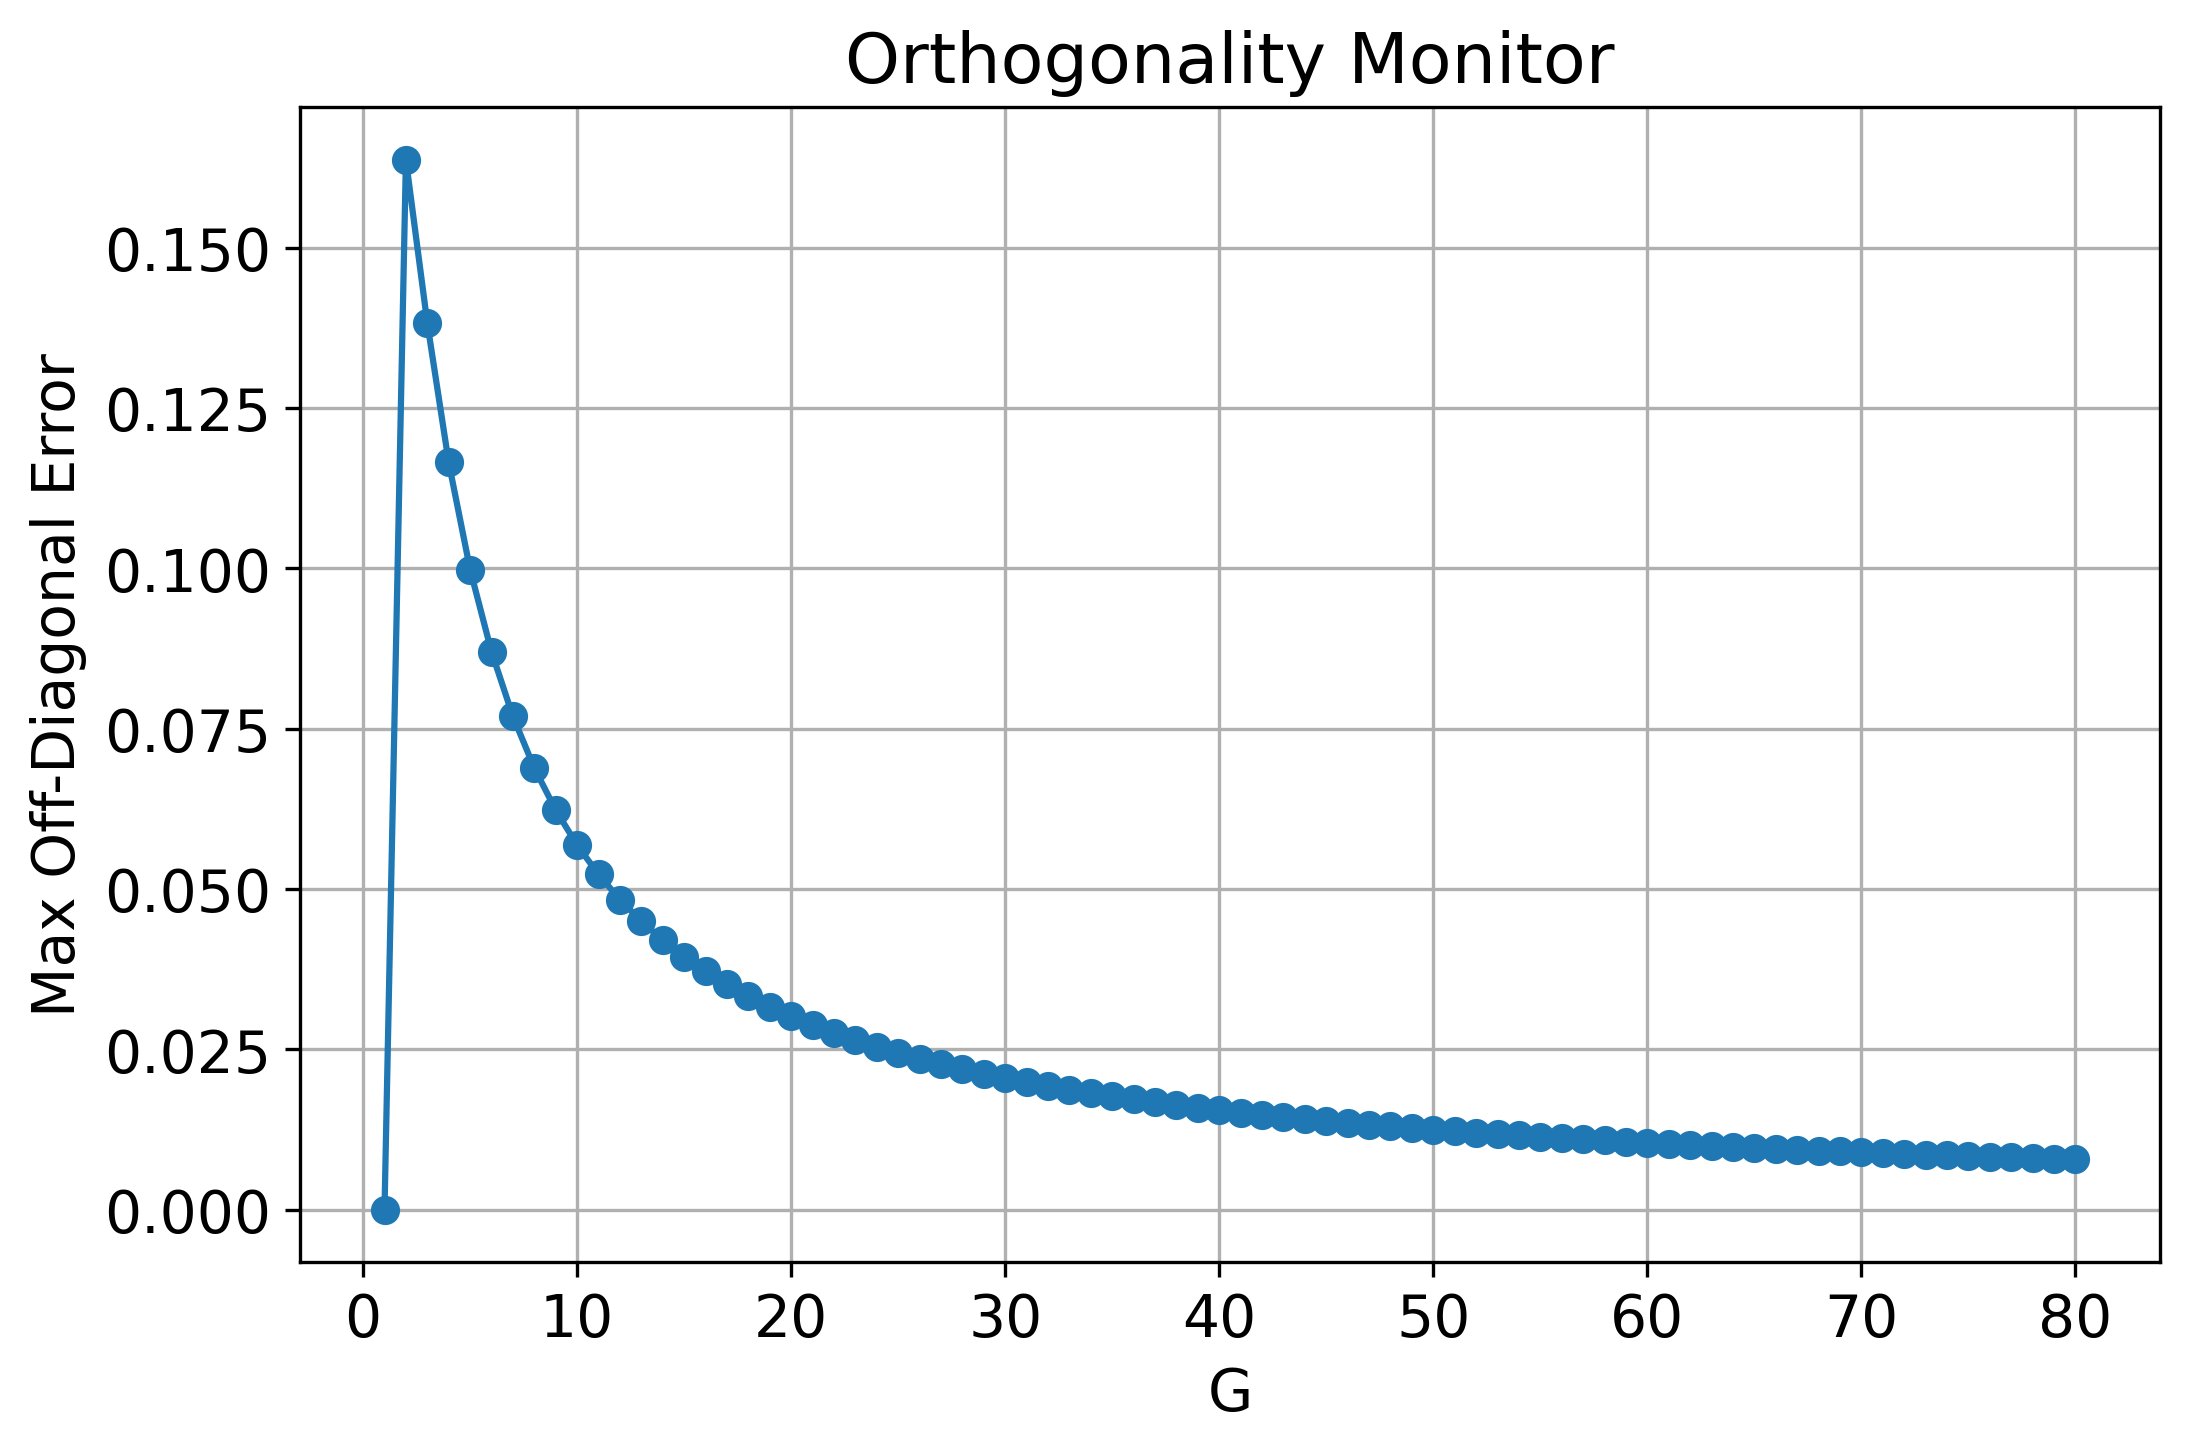

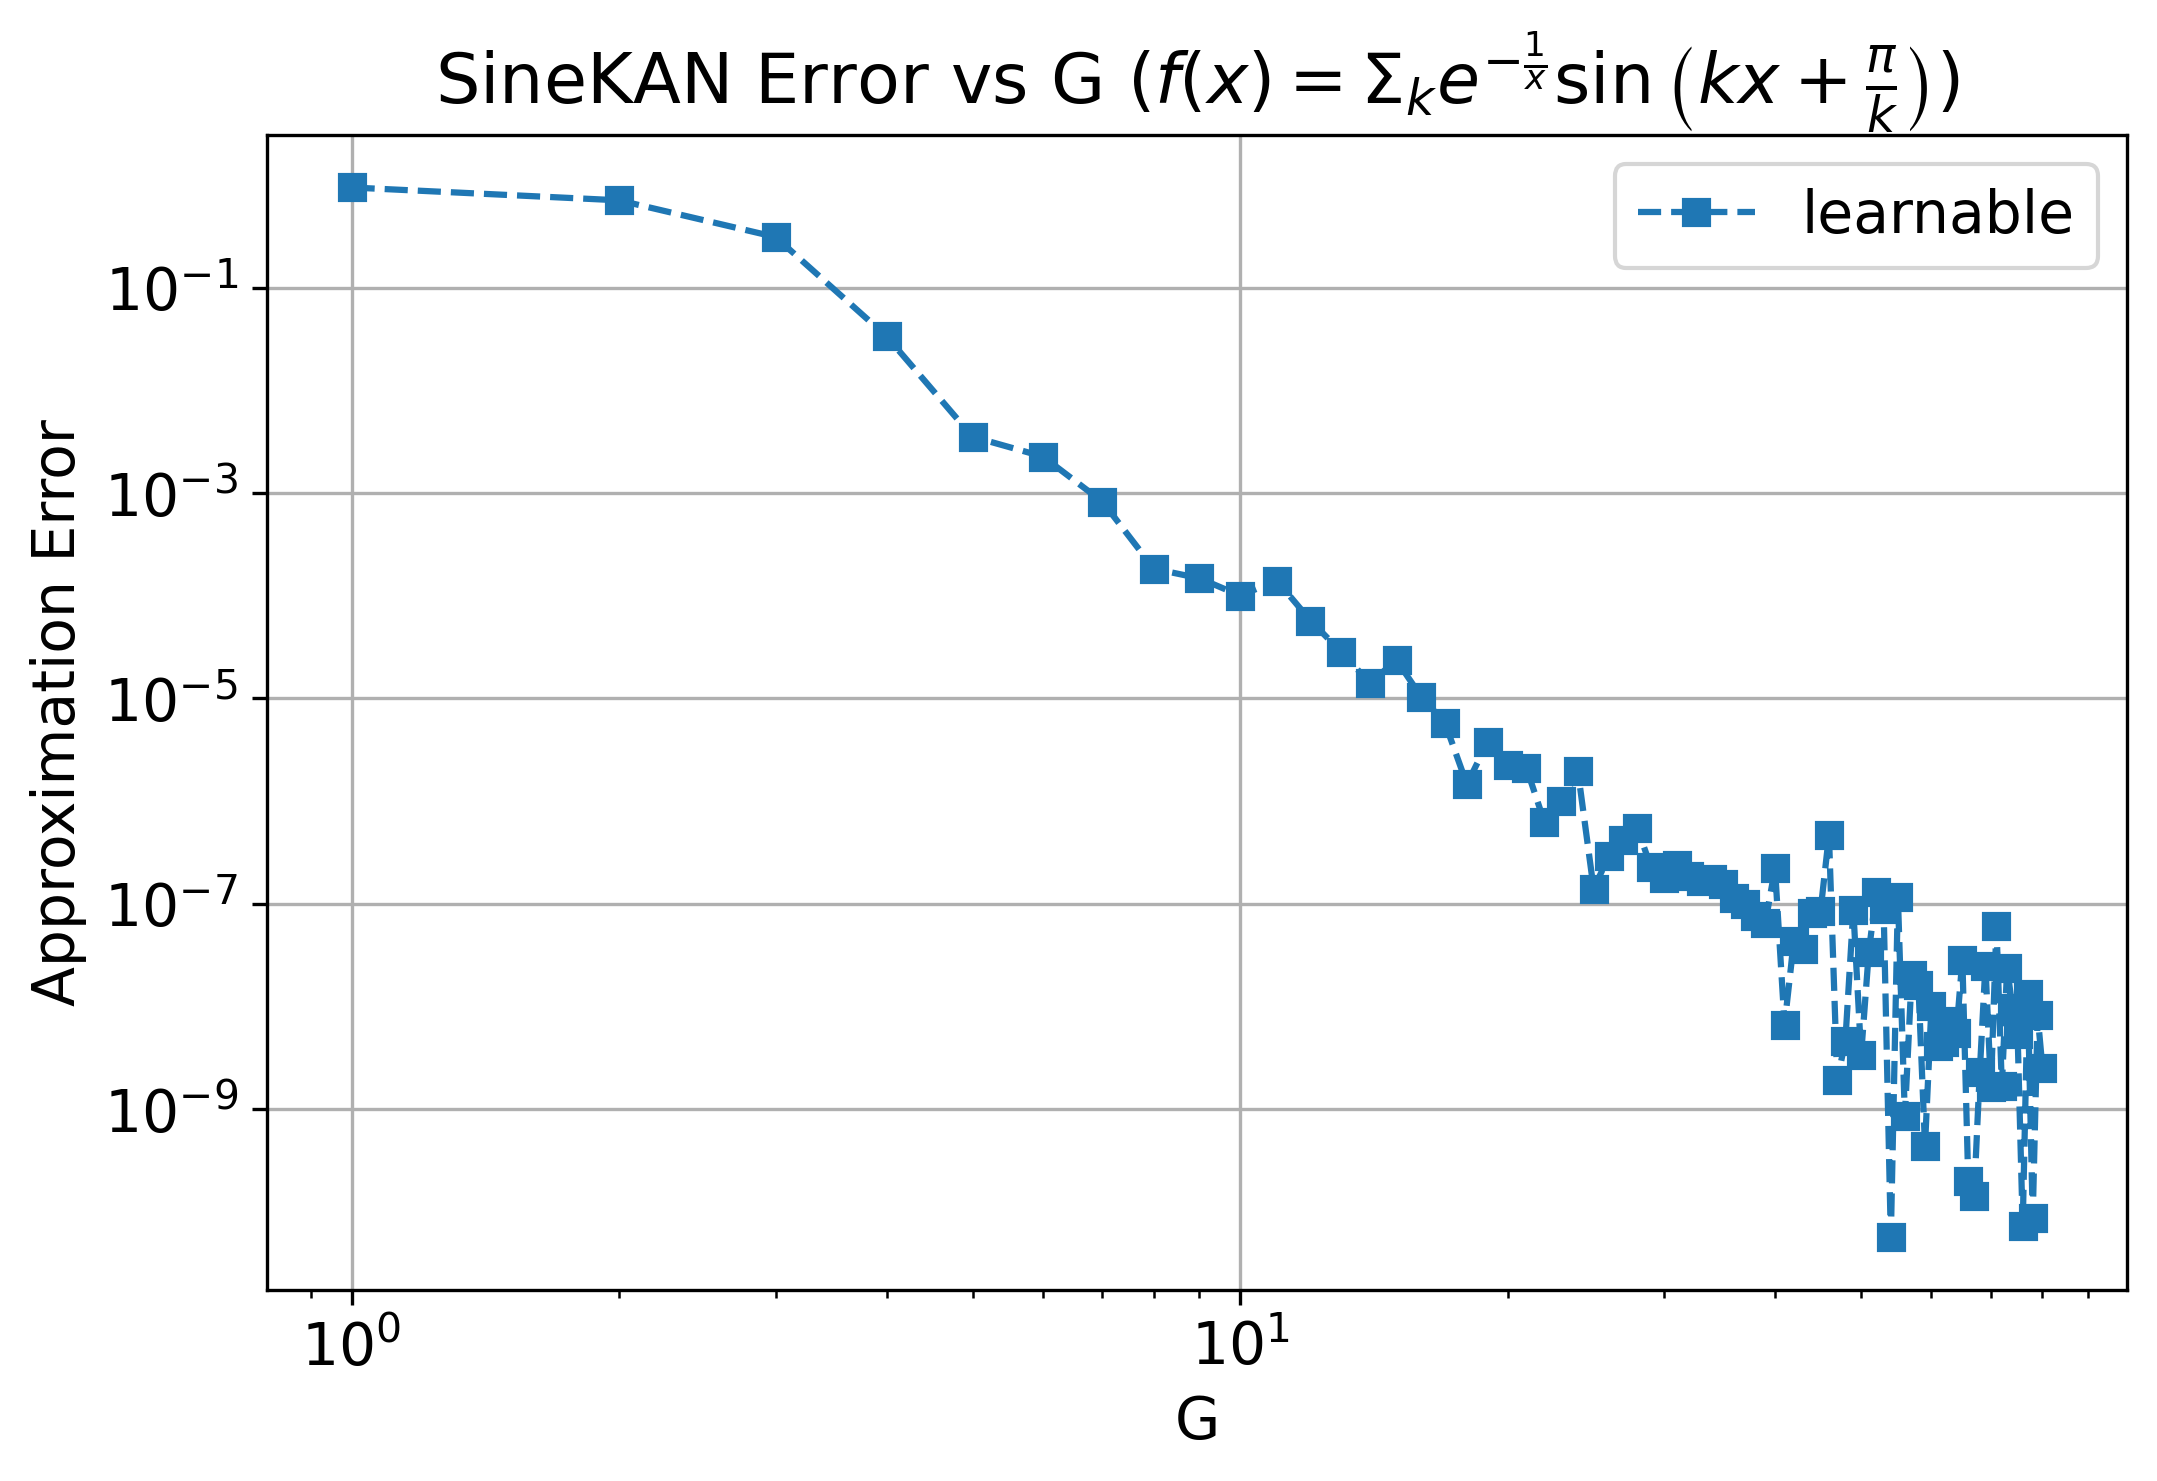

G=1: Max off-diag ortho error=0.00e+00
 G=1: Learned omegas [1.0630049]
G=1: Approx error=4.58e-01, bias=-1.76e+00

G=2: Max off-diag ortho error=1.64e-01
 G=2: Learned omegas [5.72797502 5.42522734]
G=2: Approx error=3.76e-01, bias=4.53e-01

G=3: Max off-diag ortho error=1.38e-01
 G=3: Learned omegas [0.02397758 4.70082128 8.32421341]
G=3: Approx error=3.30e-01, bias=1.44e+01

G=4: Max off-diag ortho error=1.16e-01
 G=4: Learned omegas [-3.05218247  7.98309974 13.0039683  12.68721989]
G=4: Approx error=2.73e-01, bias=-2.89e+00

G=5: Max off-diag ortho error=9.98e-02
 G=5: Learned omegas [ 1.56786731 13.23311849 17.62572892 23.27454956 23.43254022]
G=5: Approx error=2.59e-01, bias=-1.15e+00

G=6: Max off-diag ortho error=8.70e-02
 G=6: Learned omegas [ 8.67800337  2.49103879 14.11280226 13.84190772 19.37397676 24.54679561]
G=6: Approx error=2.30e-01, bias=2.56e+01

G=7: Max off-diag ortho error=7.69e-02
 G=7: Learned omegas [-3.33365202 20.06940614  8.04988542 13.663511   19.39644757 2

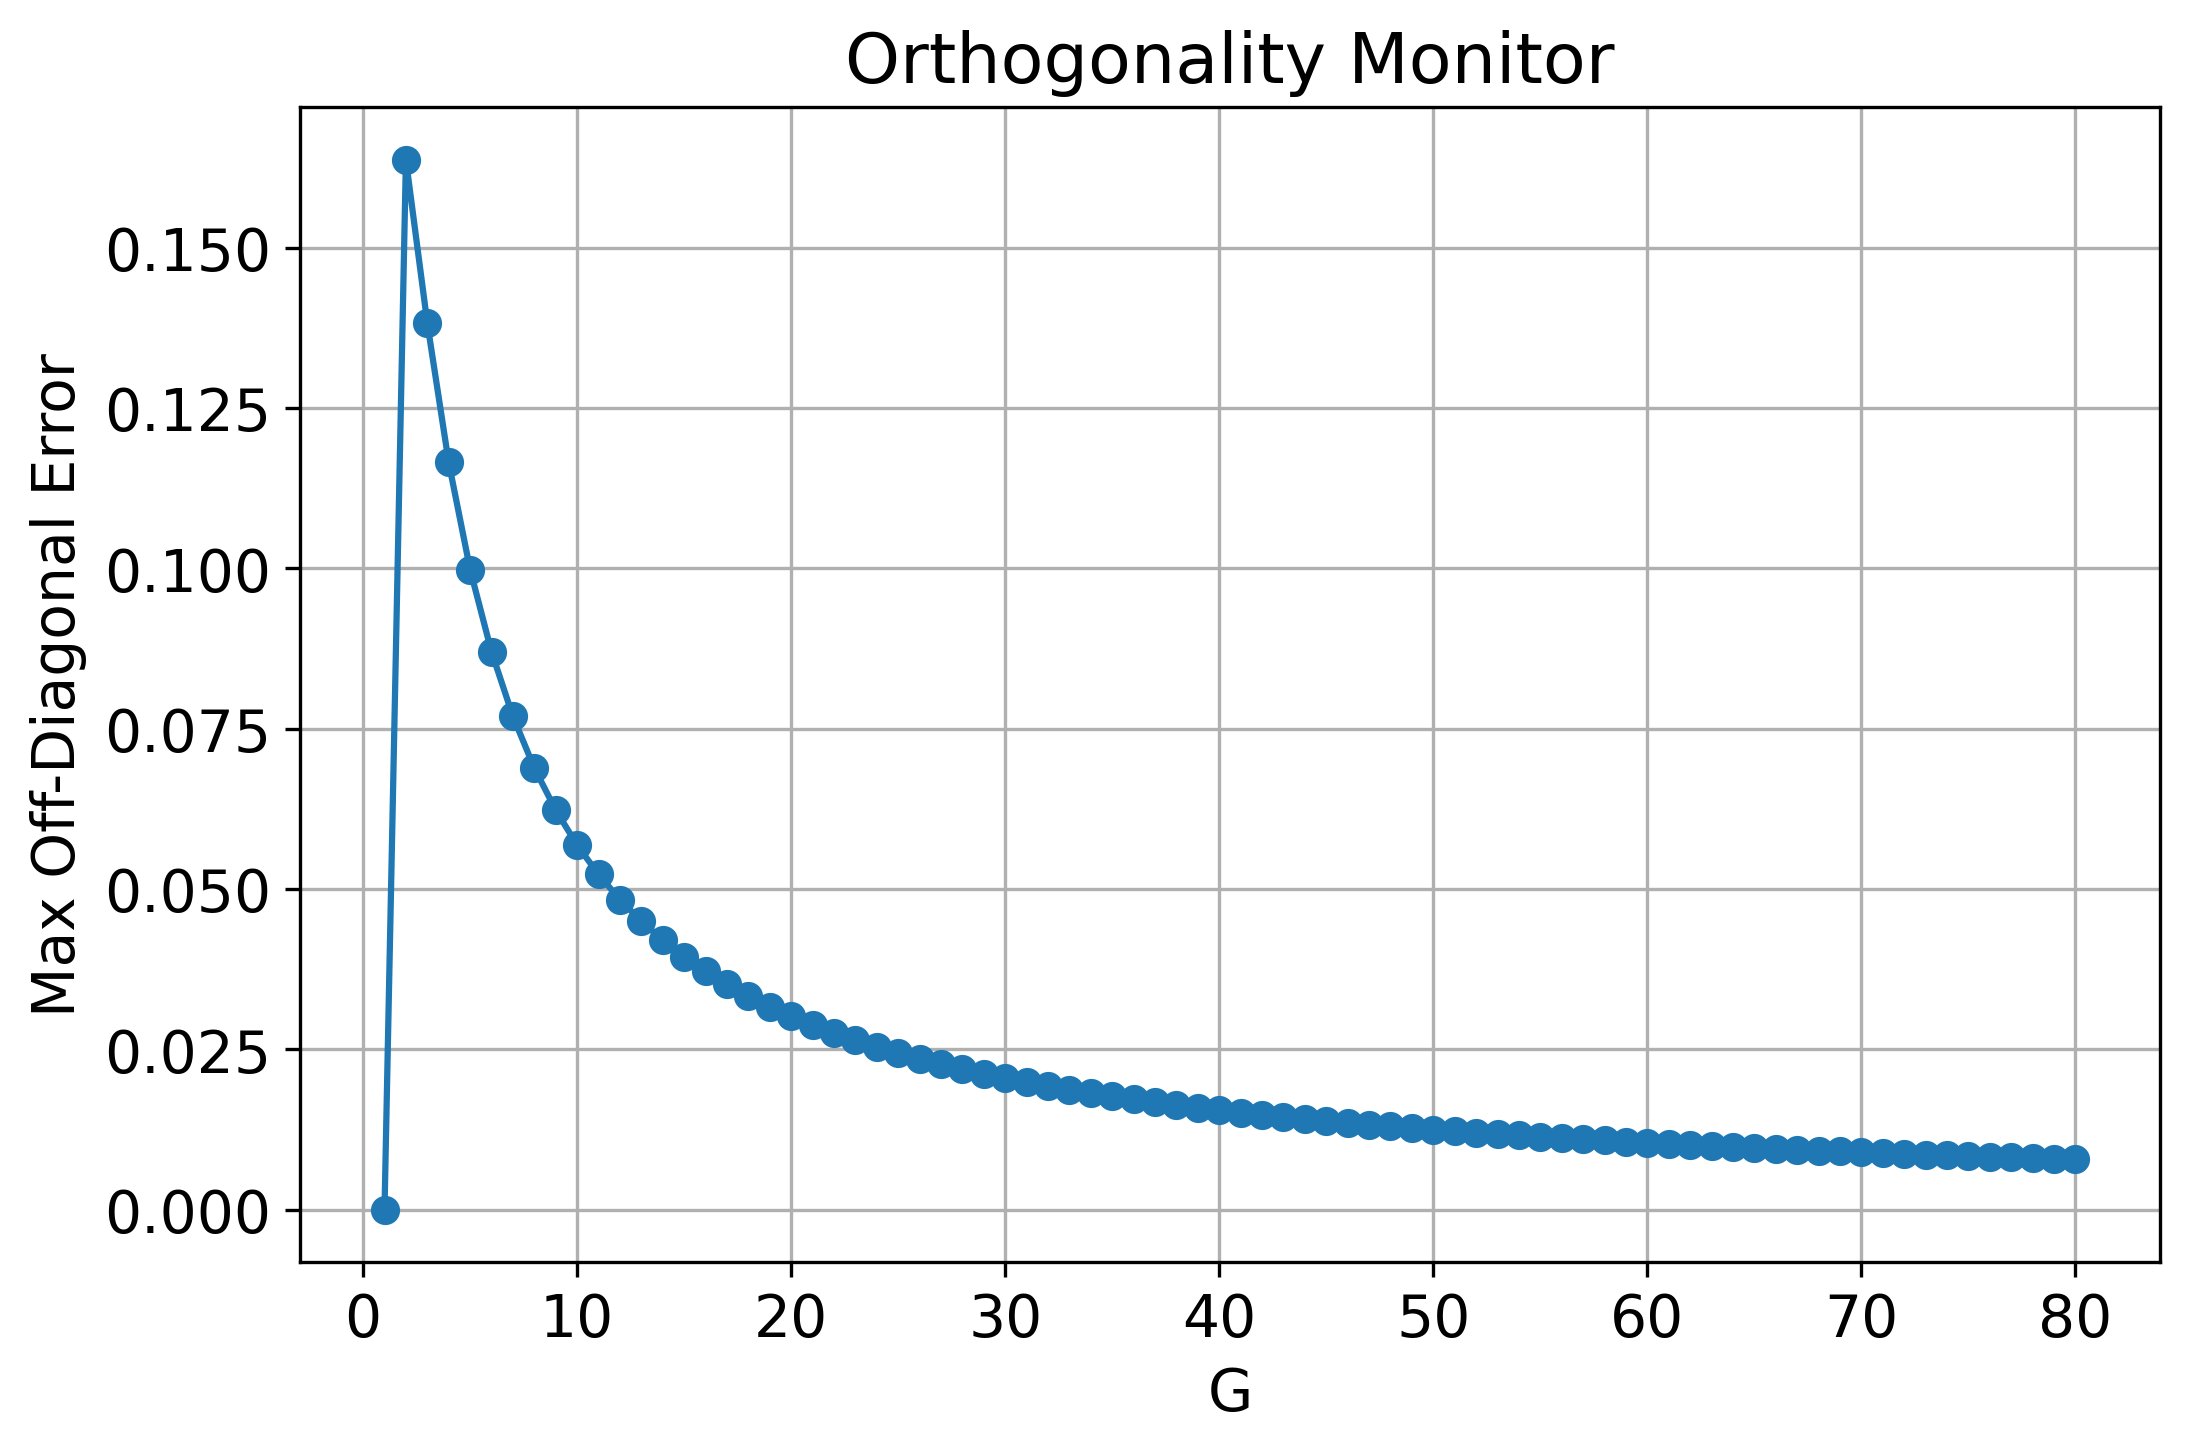

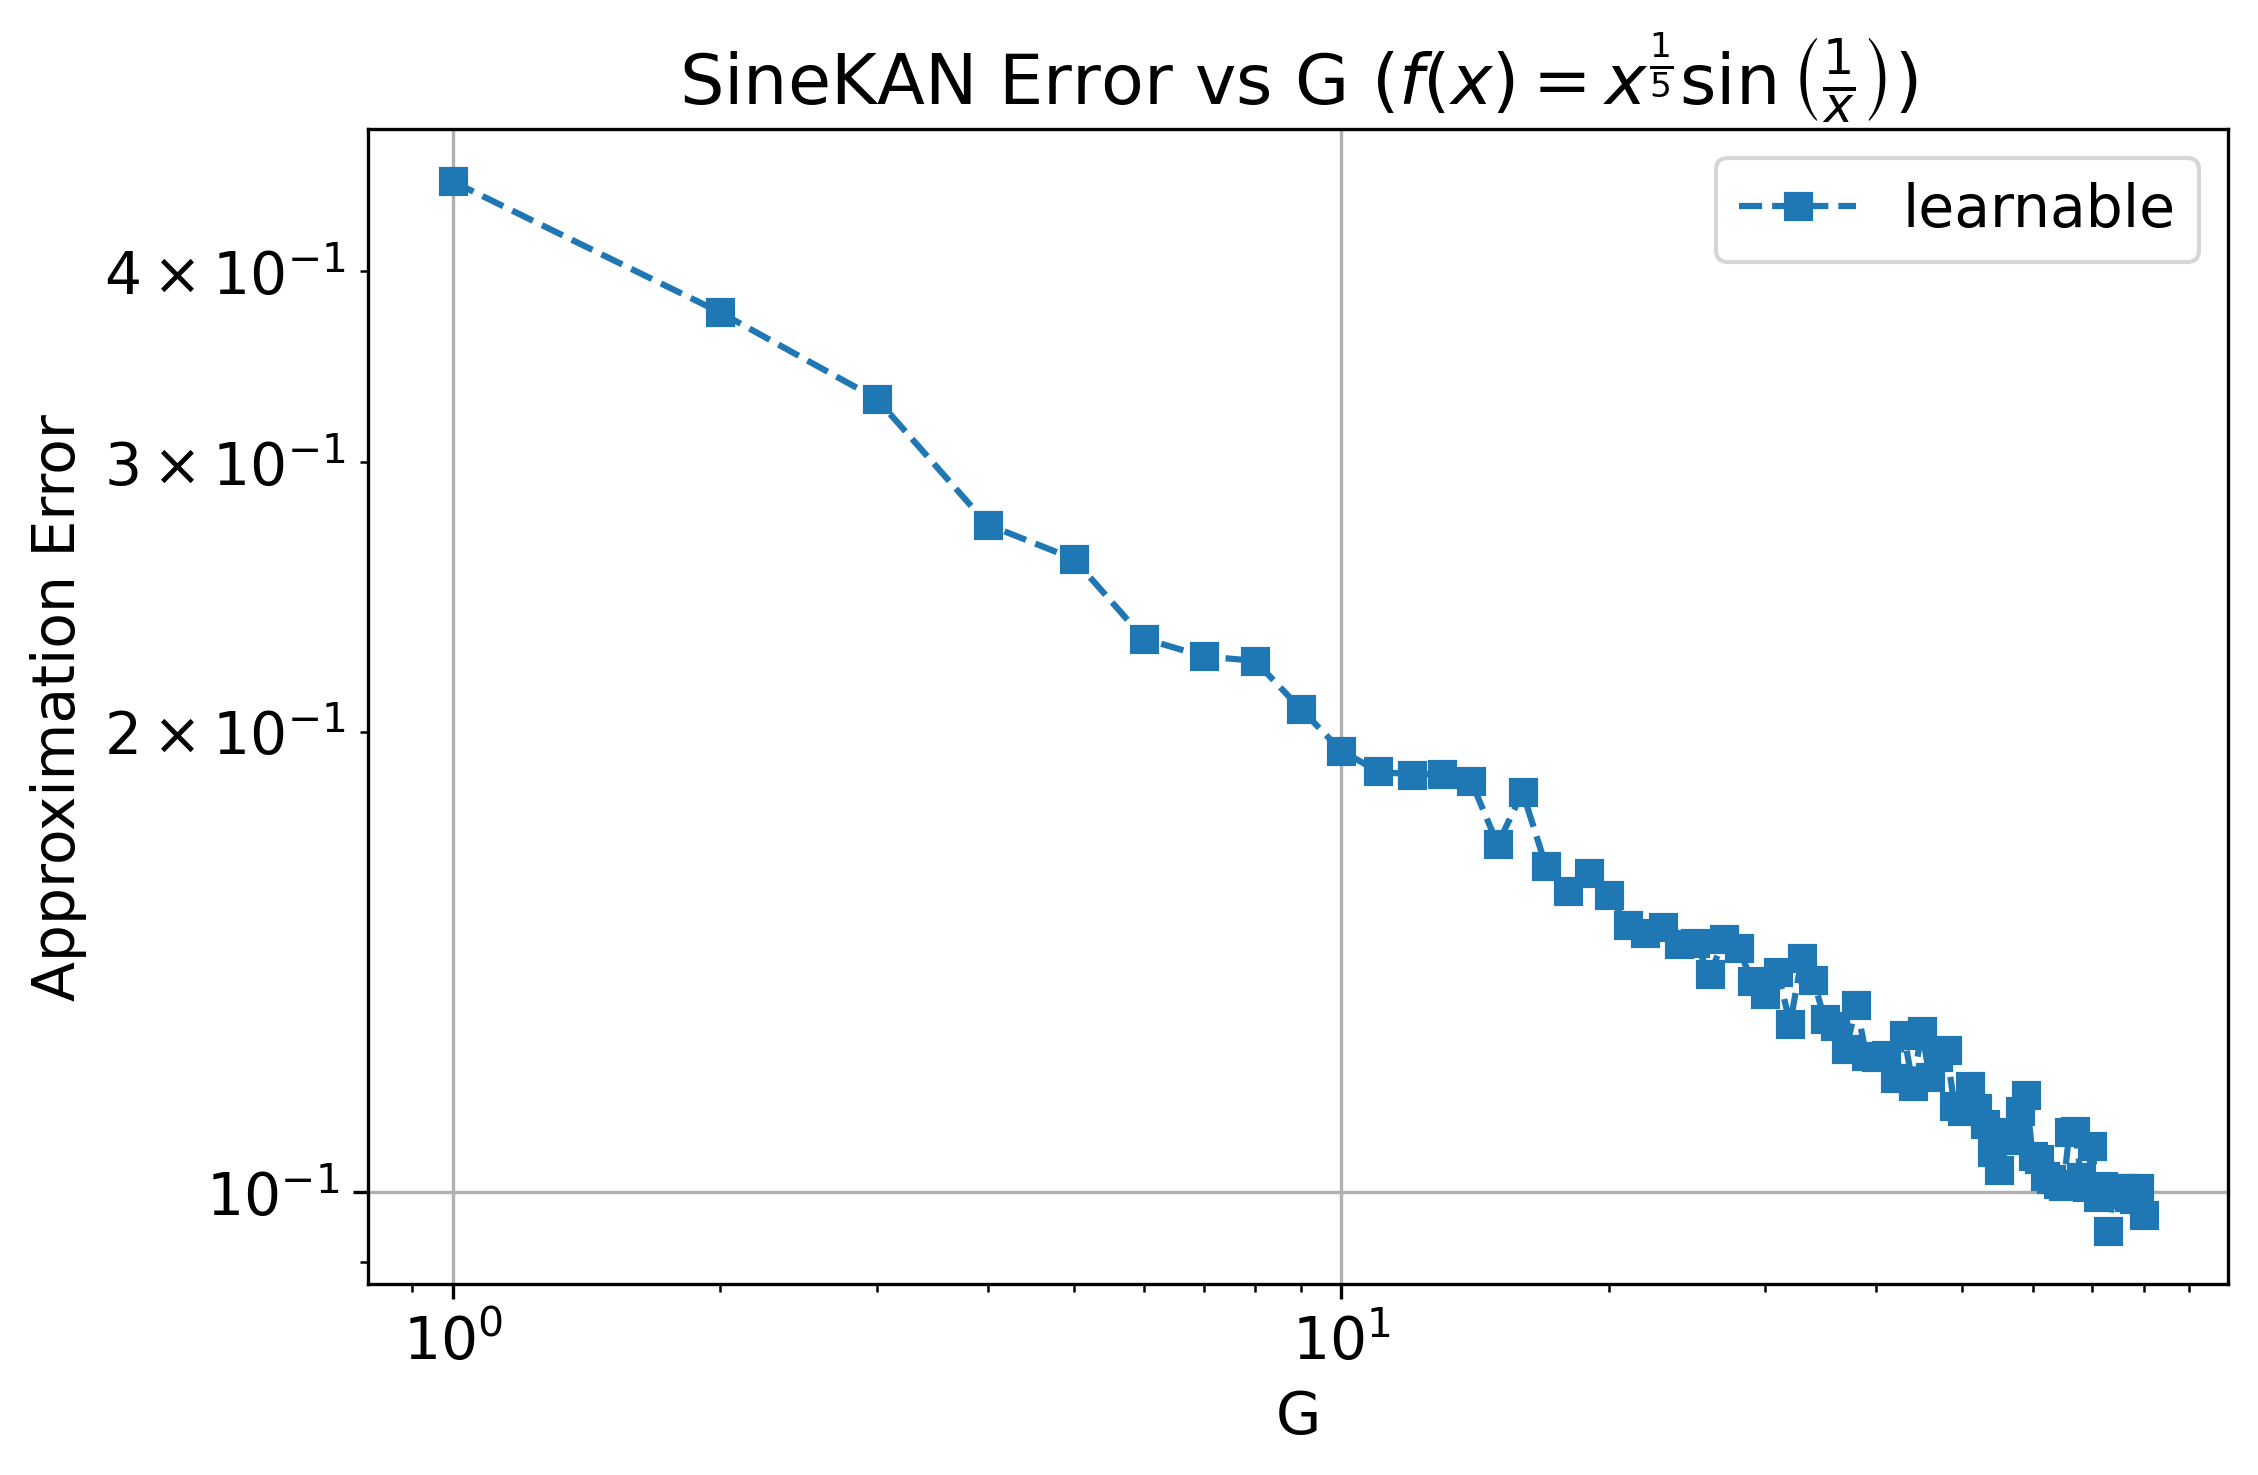

G=1: Max off-diag ortho error=0.00e+00
 G=1: Learned omegas [0.5387405]
G=1: Approx error=2.72e-01, bias=-1.81e+00

G=2: Max off-diag ortho error=1.64e-01
 G=2: Learned omegas [5.22211103 4.89775205]
G=2: Approx error=1.82e-01, bias=3.97e-01

G=3: Max off-diag ortho error=1.38e-01
 G=3: Learned omegas [-5.94425611 -0.02266464  8.40681565]
G=3: Approx error=1.44e-01, bias=1.03e+01

G=4: Max off-diag ortho error=1.16e-01
 G=4: Learned omegas [-4.93688992 -3.08758385 18.20314047 13.37451981]
G=4: Approx error=9.92e-02, bias=2.44e-02

G=5: Max off-diag ortho error=9.98e-02
 G=5: Learned omegas [ 5.74570548 -0.51649603  5.05853954 19.64399476 14.82229789]
G=5: Approx error=9.57e-02, bias=1.05e+00

G=6: Max off-diag ortho error=8.70e-02
 G=6: Learned omegas [ 8.66152013 -3.68046616 14.06969983 13.80063879 19.27147098 24.38001745]
G=6: Approx error=7.49e-02, bias=4.24e+00

G=7: Max off-diag ortho error=7.69e-02
 G=7: Learned omegas [-4.71802205  8.59998997 13.95953873 20.71869038 25.76176345 

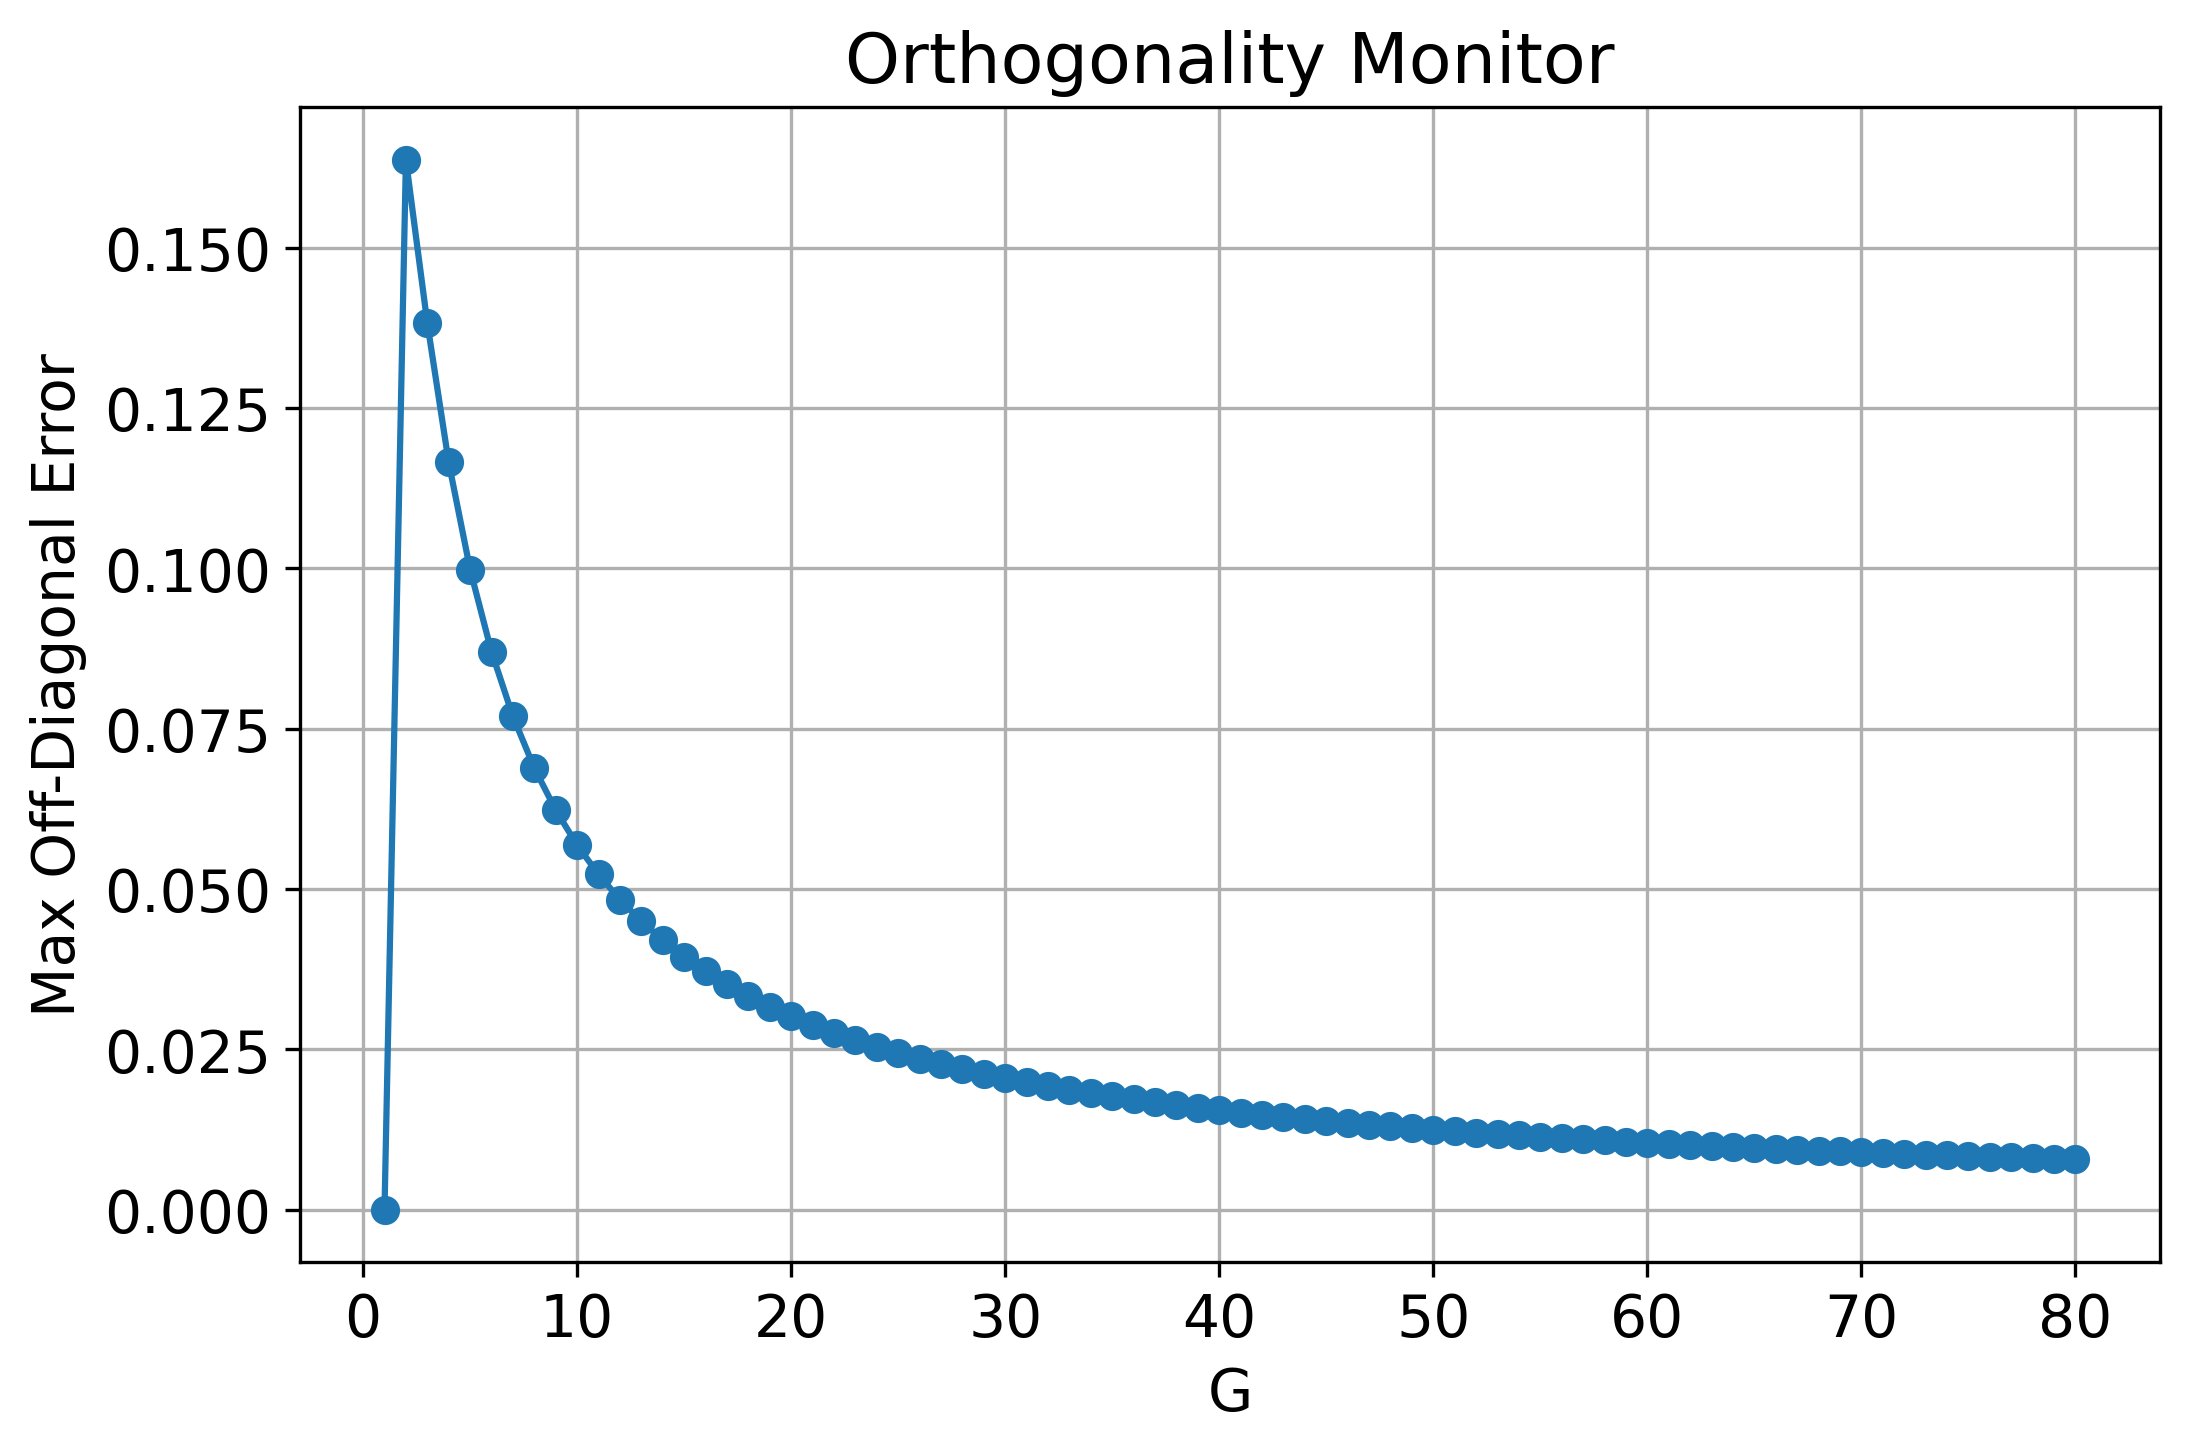

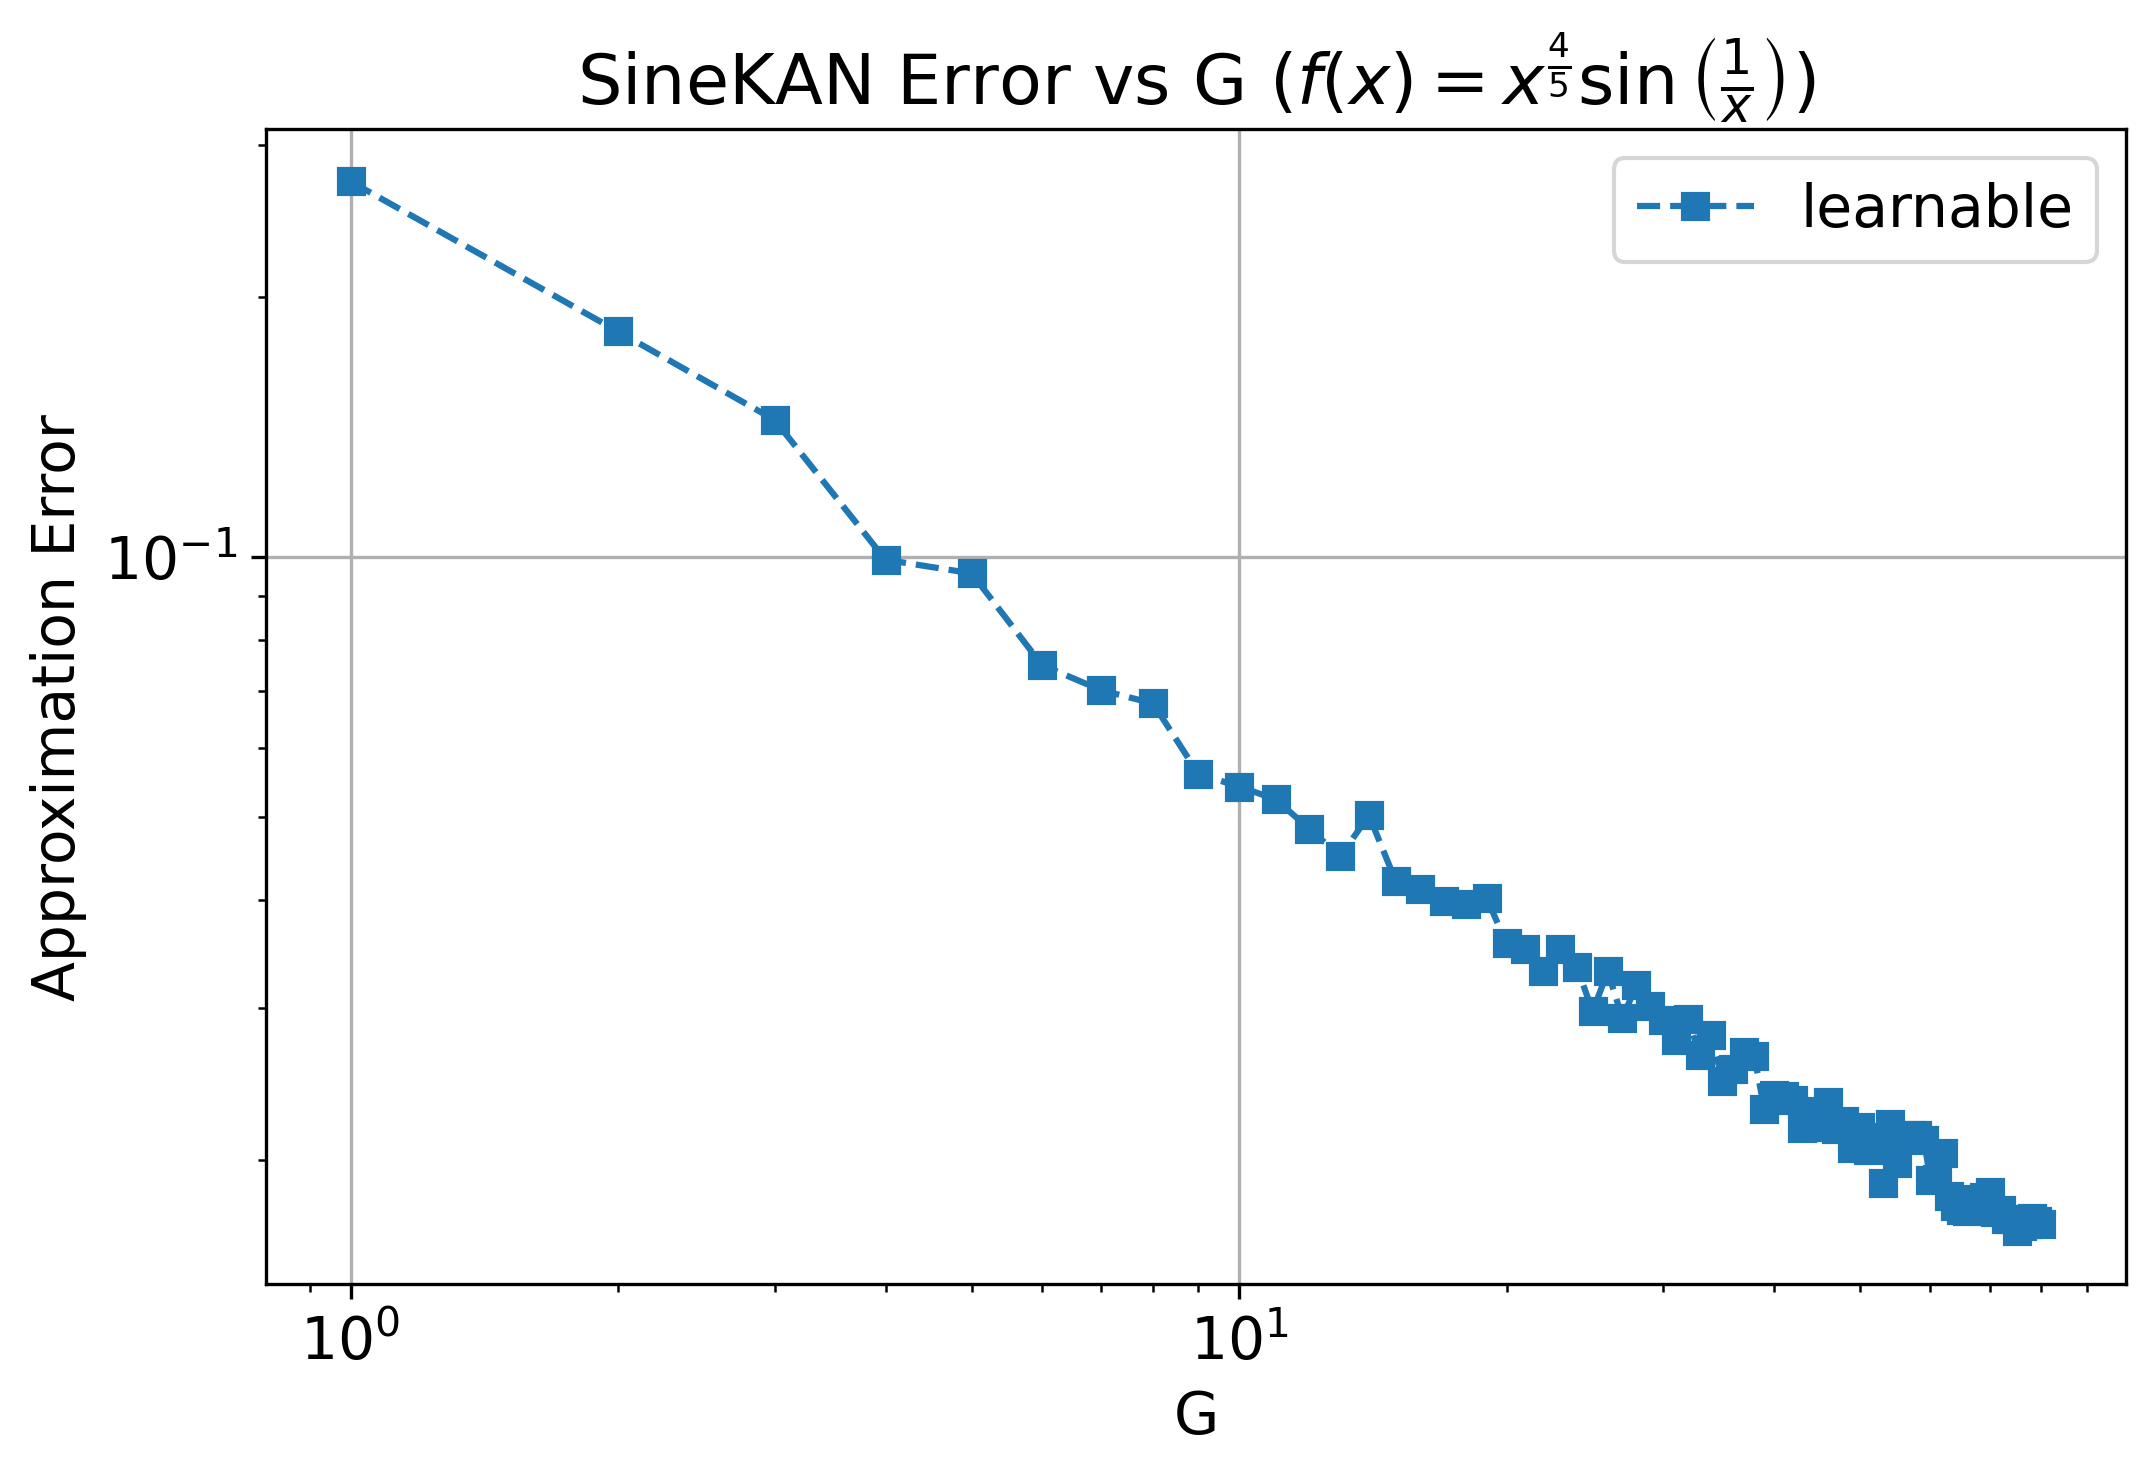

In [ ]:
sinekan_fit_info = []
sinekan_errors = []
for test_func,function_name in zip(test_funcs, function_names_latex):
    fit_info = fit(test_func, function_name,
                    np.pi, '$\pi$',
                    x_values, G_max=G_max,
                    learnable=True)
    sinekan_fit_info.append(fit_info)
    sinekan_errors.append(fit_info[0])

In [ ]:
import pickle as pkl
with open('/content/drive/MyDrive/sinekan_fit_info.pkl', 'wb') as f:
    pkl.dump(sinekan_fit_info, f)
with open('/content/drive/MyDrive/sinekan_errors.pkl', 'wb') as f:
    pkl.dump(sinekan_errors, f)